# Ising Model as a Playground

Consider the classical 2D Ising Hamiltonian
$$\mathcal{H}[\{s_i\}]=-J\,\sum_{NN} s_i\,s_j- H\,\sum\,s_i$$ 
for a given configuration of spins $\{s_i\}$ on an $L^2$ lattice with periodic boundary conditions and nearst neighbor (NN) interactions. We will use Monte-Carlo techniques to simulate the partition function 
$$\mathcal{Z}=\exp\left(-\beta \sum_{\{s_i\}} \mathcal{H}[\{s_i\}]\right)$$

In this notebook, we will examine aspects of Markov Chain Monte Carlo. Then using the simulated data, test various data analysis techniques. The idea of this notebook is to tie together the physics of the Ising model, Monte Carlo simulations, and statistical analysis into one project. Below we give a rough sketch of the outline of this project.

__Overview of ideas:__
1. Exact computation of Ising model for small lattices - L = 2,3,4
    - Generation of configurations, thermodynamic functions, density of states, energy distributions
    - Computational complexity - basic algorithm scaling
    - Zeros of partition functions - complex H and complex T
2. Markov Chain Monte Carlo
    - Implementations: Metropolis-Hastings, Swedsen-Wang, Wolff, Heatbath, and Wang-Landau
    - Diagnostics of MCMC: equilibriation, trace plots, initial condition dependence, autocorrelation
    - Error analysis: benchmarking against exact results, effective sample size, thinning, batching, jackknife, bootstrap
    - Extensions: rewighting (multiple histogram reweightings), parallel tempering, simulated annealing
3. Statistical methodology playground:
    - PCA on raw spin configurations and on the energy-order parameter phase space (E,M)
    - Maximum likelihood, fisher information, and estimation of the temperature
    - Multiple layer perceptron for classifying phases
    - Logistic regression for $J$.

__Sources:__
1. [Bryan Clark - Computing in Physics (Course notes)](https://clark.physics.illinois.edu/html/Ising/Measure.html) For details on implementation and RG 
<!-- 2. [here](https://sites.physics.wustl.edu/gradcomputer/wiki/images/6/63/Ising_notes_v2.pdf) ( not acutally used ) -->
3. [Prof. Bernd A. Berg - Markov Chain Monte Carlo Simulations (Course notes)](http://www.hep.fsu.edu/~berg/teach/mcmc08/material/lecture07mcmc3.pdf) For detatils on autocorrelation time. See full [text](https://www.amazon.com/Markov-chain-simulations-statistical-analysis/dp/9812389350) for many details on implementation for statistical systems - __likely the best resource in that regard__.
5. __Ross - Introduction to Probability Models__: For general properties of Markov Chains
6. __Barbu and Zhu - Monte Carlo Methods__: For a techinical definiton and aspects of the Metropolis Hastings Algorithm; underlying notions of detailed balance and stationarity; and the relevance of the Perron–Frobenius theorem
7. __Casella and Bergman - Statistical Inference__: For details on maximum likelihood estimation, likelihood ratio tests, and Fisher information/Cramer-Rao bound.
8. __Carl Sigman -__ [__Lecture Notes on Stochastic Modeling I, Section 4__](http://www.columbia.edu/~ks20/stochastic-I/stochastic-I.html): For general properties of Markov Chains, particularly the effect of aperiodicity.
9. __Timothy Budd - Monte Carlo Techniques__: Jupyter book and lecture notes. Discussion of Wolff algorithm and Monte Carolo error analysis.
10. __Kari Rummukainen - Monte Carlo simulation methods:__ [webpage](https://www.mv.helsinki.fi/home/rummukai/lectures/montecarlo_oulu/) - rewighting, error analysis

__Additional sources:__
1. See my handwritten notes
2. My [notebook](./Basic_Statistical_Models.ipynb) on statistical models
3. Perplexity AI

# Exact Ising Model Computations for Small Lattices

It will be helpful to have exact results at hand to benchmark our Monte Carlo techniques. To obtain these for small square lattices with $L = 2,3,4$, we enumerate the set of all $2^{L^2}$ spin configurations, define the partition function and other thermodynamic functions on this set, and compute corresponding thermal averages. 

It is additionally useful to compute the density of states in this fashion. The computation quickly becomes prohibitively costly for $L >5$. However, see this [article](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.76.78) on the exact density of states for square lattice nearest neighbor Ising model. See [link](https://spot.colorado.edu/%7Ebeale/MathematicaFiles/) for Mathematica notebooks which compute the exact results for a given $n \times m$ lattice. See also this [stack exchange discussion](https://physics.stackexchange.com/questions/335631/ising-model-density-of-states) on enumerating the density of states for $d=1,2$.

For performing a maximum likelihood estimation of the temperature, we will need probablity and log probabilities of specific energies as well as samples of energies. We detail some of this below.

The probabiltiy of a given energy observation is $p(E_k)=\mathcal{Z}(\beta)^{-1}\exp(-\beta E_k)$. Thus, for a random (independent) sample $\{E_i\}_{i=1,N}$, $p(\{X_i\})=\mathcal{Z}(\beta)^{-N}\exp(-\beta \sum_{i=1}^N E_i)$. Or in terms of the sample mean, $p(\bar{E})=\mathcal{Z}(\beta)^{-N}\exp(-\beta N \bar{E})$. This is all well and good for non-degenerate systems, but there is degeracy here since there are multiple configurations (states) which correspond to the same energy. 

To account for this, we introduce a multiplicative factor $\Omega(E)$ which counts the number of states with energy $E$:

\begin{eqnarray}
p(E_k)=\mathcal{Z}(\beta)^{-1}\sum_{E=E_k}\exp(-\beta E)=\mathcal{Z}(\beta)^{-1}\Omega(E_k)\exp(-\beta E_k)
\end{eqnarray}

So then the probability of measuring a sample $\{E_i\}_{i=1,N}$ becomes

\begin{eqnarray}
p(\bar{E})&=& \Pi_{i=1}^N p(E_i)=\mathcal{Z}(\beta)^{-N}\Pi_{i=1}^N \Omega(E_i)\exp(-\beta E_i)
\end{eqnarray}

### Configuration generator and binary representation map for configurations

In [2]:
import itertools, numpy as np

In [3]:
def config_gen(L):
    '''Function to generate all lattice configurations for a given linear size L '''
    perm = [list(seq) for seq in itertools.product("ab", repeat=L*L)]
    perm = np.array(perm).reshape(2**(L*L), L, L)
    perm = np.where(perm=="a", 1, -1)
    return perm

In [4]:
def binary_rep(M):
    ''' Function to map configurations to binary then a number between 0 and 2**N-1  '''
    N=np.shape(M)[0]
    M=np.reshape(M,N*N)
    M=np.where(M==-1,0,1)
    return sum([M[i]*2**i for i in range(len(M))])

### Ising model Hamiltonian

In [6]:
def Ham(Latt,H):
    ''' The Hamiltonian for a square LxL lattice Ising model with
    nearest neighbor interactions and magnetic field H. We take J=1 and use scaled temperature $T=J/T$ '''
    J = 1
    L = len(Latt) 
    Sum_H = -H*np.sum(Latt)
    Sum_J = 0
    for i in range(L):
        for j in range(L):
            # move through lattice and compute s_i * neighbors
            Sum_J += -J * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                        + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
    return ( Sum_J/2 + Sum_H )

### Functions determining degeneracy and probablity distribution of energies

In [7]:
def E_list(L):
    ''' Computes nearest neighbor energies for all configurations for a given N at H=0'''
    return [Ham(M,0) for M in config_gen(L)]

def deg_E(L): 
    ''' Counts occurences of each E in E_list(N), returns the set of (E, deg(E)) '''
    el = E_list(L)
    degen = sorted([ (x,el.count(x)) for x in set(el)])
    #return [ i for i,j in degen]
    return degen

def degen_gen(E,L): 
    ''' Degenracy computation. This is too slow. Best to compute once degen_set and use in later functions'''
    degen_set = np.array(deg_E(L))
    i = np.where(degen_set[:,0] == E)[0][0]
    return degen_set[i][1]

In [8]:
# functions below use a global precomputed result for the energies and degeneracies for $L=2,3,4$
# In this cell, we compute once and for all the degeneracies used 

E_set = [ set(E_list(n)) for n in [2,3,4]]
degen_set = [deg_E(n) for n in [2,3,4]]

In [9]:
# def part_func(L,T,H):
#     ''' The partition function for a square LxL lattice, 
#     nearest neighbor interactions, at temperature T and magnetic field H '''
    
#     return np.sum([np.exp(-1/T*Ham(M,H)) for M in config_gen(L) ])

def prob_E(L,T,H,E):
    ''' A function to the compute probabiliy of given energy E of 
    a square LxL lattice, nearest neighbor interactions, at temperature T and magnetic field H '''
    
    i = [2,3,4].index(L)
    degen_set_here = np.array(degen_set[i])
    if H != 0:
        el = [ Ham(M,H) for M in config_gen(L)]
        degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
    def degen(Es):
        j = np.where(degen_set_here[:,0] == Es)[0][0]
        return degen_set_here[j][1]
    part_func = np.sum( [g*np.exp(-1/T*e) for e,g in degen_set_here])
    return part_func**(-1)*degen(E)*np.exp(-1/T*E)

def prob_Eset(L,T,H,E_samples): 
    ''' A function to compute the probabiliy of a given sample of energies E_samples
    of a square LxL lattice, nearest neighbor interactions, at temperature T and magnetic field H '''

    n = len(E_samples)
    i = [2,3,4].index(L)
    degen_set_here=np.array(degen_set[i])
    if H != 0:
        el = [ Ham(M,H) for M in config_gen(L)]
        degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
    def degen(Es):
        j = np.where(degen_set_here[:,0] == Es)[0][0]
        return degen_set_here[j][1]
    part_func = np.sum( [g*np.exp(-1/T*e) for e,g in degen_set_here])
    return part_func**(-n)*np.prod( [(degen(e)*np.exp(-1/T*e))**(E_samples.count(e)) for e in set(E_samples) ] )

def log_prob_Eset(L,T,H,E_samples):
    ''' A function to compute the log-probabiliy of a given sample of energies E_samples
    of a square LxL lattice, nearest neighbor interactions, at temperature T and magnetic field H '''

    n = len(E_samples)
    i = [2,3,4].index(L)
    degen_set_here = np.array(degen_set[i])
    if H != 0:
        el = [ Ham(M,H) for M in config_gen(L)]
        degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
    def degen(Es):
        j = np.where(degen_set_here[:,0] == Es)[0][0]
        return degen_set_here[j][1]
    part_func = np.sum( [g*np.exp(-1/T*e) for e,g in degen_set_here])
    return -n*np.log(part_func) + np.sum([E_samples.count(E)*(-1/T*E +np.log(degen(E))  ) for E in set(E_samples) ])     

In [10]:
# def mean_E(L,T,H):
#     ''' Computes mean energy for (L,T,H)'''
#     i = [2,3,4].index(L)
#     el = sorted(list(set(E_list(L))))
#     degen_set_here = np.array(degen_set[i])
#     if H != 0:
#         el = [ Ham(M,H) for M in config_gen(L)]
#         degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
#     def degen(Es):
#         j = np.where(degen_set_here[:,0] == Es)[0][0]
#         return degen_set_here[j][1]
#     return part_func(L,T,H)**(-1)*np.sum([e*degen(e)*np.exp(-1/T*e) for e in el])

# def var_E(L,T,H):
#     '''Computes variation of energy for (L,T,H)'''
#     i = [2,3,4].index(L)
#     el = sorted(list(set(E_list(L))))
#     e_mean = mean_E(L,T,H)
#     degen_set_here=np.array(degen_set[i])
#     if H != 0:
#         el = [ Ham(M,H) for M in config_gen(L)]
#         degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
#     def degen(Es):
#         j = np.where(degen_set_here[:,0] == Es)[0][0]
#         return degen_set_here[j][1]
#     return part_func(L,T,H)**(-1)*np.sum([(e-e_mean)**2*degen(e)*np.exp(-1/T*e) for e in el])

Energy list:  [-32.0, -24.0, -20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 32.0]


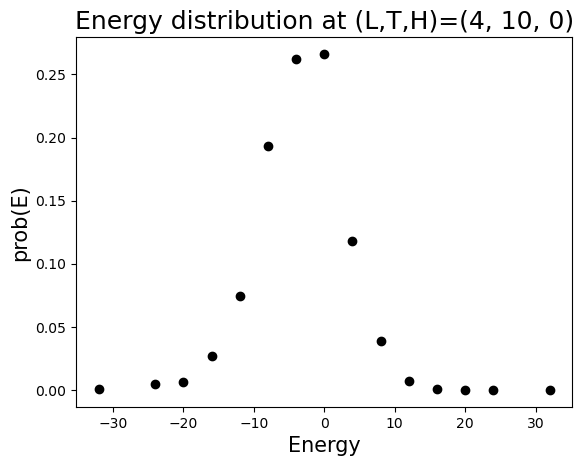

In [11]:
import matplotlib.pylab as plt

## compute histrogram and exact probablities
#elist = list(sorted(set([ Ham(M,J_NN,H) for M in config_gen(N)])))
L, T, H = 4, 10, 0
beta = 1/T
N_sites = L**2

elist = [Ham(M,H) for M in config_gen(L)]
eset = sorted(set(elist))
degeneracies = np.array([ (e, elist.count(e)) for e in eset])

partition_function = np.sum([np.exp(-1/T*e) for e in elist ])
prob_set = np.zeros_like(eset)
for i,e in enumerate(eset):
    j = np.where(degeneracies[:,0] == e)[0][0]
    degen = degeneracies[j][1]
    prob_set[i] = partition_function**(-1)*degen*np.exp(-1/T*e)

E_mean = np.sum( [e*p for e,p in zip(eset,prob_set)] )

print("Energy list: ", eset)
fig, ax = plt.subplots(1,1)
ax.scatter(eset, prob_set, color = "black", label = "Theory") 
ax.set_xlabel("Energy",fontsize = 15) 
ax.set_ylabel("prob(E)" ,fontsize = 15)
plt.title(f"Energy distribution at (L,T,H)={(L,T,H)}",fontsize=18)
plt.show()

Energy list:  [-32.16, -31.84, -24.14, -23.86, -20.12, -19.88, -16.12, -16.1, -16.08, -16.0, -15.92, -15.9, -15.88, -12.1, -12.08, -12.06, -12.04, -12.02, -11.98, -11.96, -11.94, -11.92, -11.9, -8.1, -8.08, -8.06, -8.04, -8.02, -8.0, -7.98, -7.96, -7.94, -7.92, -7.9, -4.08, -4.06, -4.04, -4.02, -4.0, -3.98, -3.96, -3.94, -3.92, -0.08, -0.06, -0.04, -0.02, 0.0, 0.02, 0.04, 0.06, 0.08, 3.94, 3.96, 3.98, 4.0, 4.02, 4.04, 4.06, 7.94, 7.96, 7.98, 8.0, 8.02, 8.04, 8.06, 11.96, 11.98, 12.0, 12.02, 12.04, 15.96, 15.98, 16.0, 16.02, 16.04, 20.0, 23.98, 24.02, 32.0]


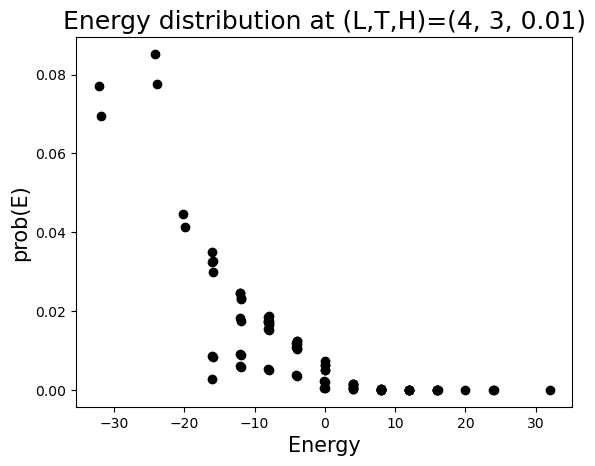

In [12]:
## compute histrogram and exact probablities
#elist = list(sorted(set([ Ham(M,J_NN,H) for M in config_gen(N)])))
L, T, H = 4, 3, 0.01
beta = 1/T
N_sites = L**2

elist = [Ham(M,H) for M in config_gen(L)]
eset = sorted(set(elist))
degeneracies = np.array([ (e, elist.count(e)) for e in eset])

partition_function = np.sum([np.exp(-1/T*e) for e in elist ])
prob_set = np.zeros_like(eset)
for i,e in enumerate(eset):
    j = np.where(degeneracies[:,0] == e)[0][0]
    degen = degeneracies[j][1]
    prob_set[i] = partition_function**(-1)*degen*np.exp(-1/T*e)

E_mean = np.sum( [e*p for e,p in zip(eset,prob_set)] )

print("Energy list: ", eset)
fig, ax = plt.subplots(1,1)
ax.scatter(eset, prob_set, color = "black", label = "Theory") 
ax.set_xlabel("Energy",fontsize = 15) 
ax.set_ylabel("prob(E)" ,fontsize = 15)
plt.title(f"Energy distribution at (L,T,H)={(L,T,H)}",fontsize=18)
plt.show()

# Computational Complexity of Lattice Functions

Below we will demonstrate that for nearest neighbor interaction, we can reduce the complexity of the spin-flip energy computation from $\mathcal{O}(N^2)$ to $\mathcal{O}(1)$. The $L^2$ behavior is due to the scan over the 2D lattice to find the neareast neighbors. Computing the Hamiltonaian this way (which is neccesary for general spin interactions) would have an even larger dependence on L - $\mathcal{O}(L^4)$ due to summing interaction of each of the $L^2$ spins with all $L^2$ other spins. 

### Spin flip energy change (poor and best implemenation)

In [12]:
def spin_flip_poor(M,H,u):
    a,b = u
    L = len(M)
    Sum_H = -H*M[a,b]
    Sum_J = 0
    for i in range(L):
        for j in range(L):
            v = np.array([i,j])
            if (i == a and j == b+1) or  (i == a and j == b-1) or (i == a+1 and j == b) or (i == a-1 and j == b):
                Sum_J += - J*M[a,b]*M[i%L, j%L]
    return ( Sum_J/2 + Sum_H )

def spin_flip(M,H,u):
    a,b = u
    L = len(M)
    Sum_H = -H*M[a,b]
    Sum_J = - J*M[a,b]*(M[a, (b+1)%L] + M[a,(b-1)%L] + M[(a+1)%L,b] + M[(a-1)%L,b] )
    return ( Sum_J + Sum_H )

In [32]:
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
from time import time

N_check=10000
N_range=np.arange(2,40,2)
time_data=[0 for N in N_range]

for i in range(len(N_range)):
    N=N_range[i]
    t0=time()
    [spin_flip(coldstart(N),0,[1,1]) for i in range(N_check)]
    t1=time()
    time_data[i]=(t1-t0)/N_check
    #print((t1-t0)/N_check)

y = 2.213093688938631e-06 + -2.0378556079555698e-08 x


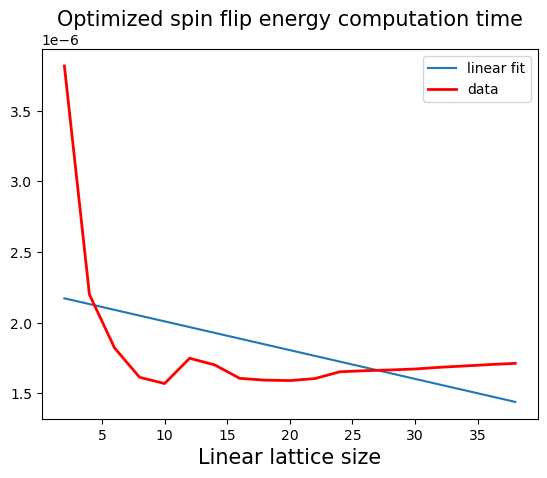

In [33]:
par,con=curve_fit((lambda x,a,b: a+b*x),N_range,time_data)
a,b=par
print(f"y = {a} + {b} x")

fig, ax = plt.subplots(1,1)
ax.plot(N_range, (lambda x,a,b: a+b*x)(N_range,a,b), label="linear fit")
ax.plot(N_range, time_data, linewidth=2, color='r', label="data")
ax.set_xlabel("Linear lattice size",fontsize=15) 
ax.set_title("Optimized spin flip energy computation time" ,fontsize=15)
plt.legend()
plt.show()

In [34]:
N_check=10000
N_range=np.arange(2,20,2)
time_data=[0 for N in N_range]
for i in range(len(N_range)):
    N=N_range[i]
    t0=time()
    [spin_flip_poor(coldstart(N),0,[1,1]) for i in range(N_check)]
    t1=time()
    time_data[i]=(t1-t0)/N_check
    #print((t1-t0)/N_check)

y=2.584985442587021e-07x^2+1.4039010500451102e-07x+2.925868155680966e-06


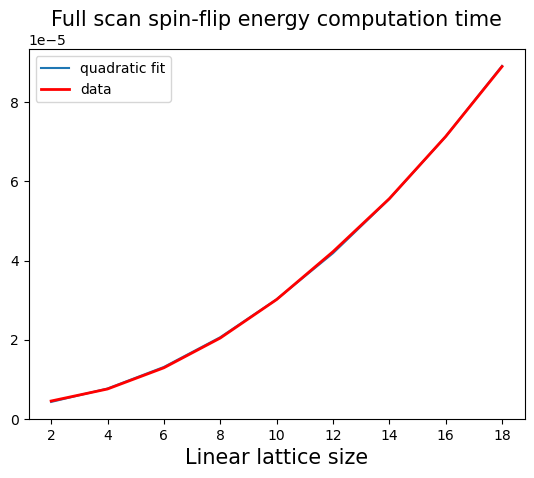

In [35]:
par,con=curve_fit((lambda x,a,b,c:a*x**2+b*x+c),N_range,time_data)
a,b,c=par
print(f"y={a}x^2+{b}x+{c}")

fig, ax = plt.subplots(1,1)
ax.plot(N_range,(lambda x,a,b,c:a*x**2+b*x+c)(N_range,a,b,c), label="quadratic fit")
ax.plot(N_range,time_data,linewidth=2, color='r', label="data")
ax.set_xlabel("Linear lattice size",fontsize=15) 
ax.set_title("Full scan spin-flip energy computation time" ,fontsize=15)
plt.legend()
plt.show()

# Monte Carlo Alogorithms

# Markov Chain Monte Carlo

1. Markov Chains
2. Markov Chain Monte Carlo (MCMC) via Metropolis-Hastings
3. The Wolff algorithm
4. The Wang-Landau algorithm for the density of states
5. The Heatbath algorithm
6. Benchmarking using exact results
7. Comparisons of algorithms using autocorrelation time

## Markov Chains

Some nice visualizations of transition matrices using code from Timothy Budd.

Using the theory of discrete Markov chains coupled with random sampling, one can generate a sequence which simulates a desired probability distribution, $\pi(x)$. There are two central notions:
1. (Perron-Froebenius) Any irreducible, aperiodic transition matrix $K$ has a long time behavior $K^n \approx I\cdot\pi$ where $\pi$ is the stationary distribution. In other words, Eigenval(K)=${\lambda_1,\lambda_2, ...}$ where $\lambda_1=1$ and $\lambda_i<0$ $\forall i>1$. These negative eigenvalues can be understood via relaxational dynamics.
2. Detailed balance implies global balance implies a stationary solution.

The idea for us to simulate a given physical model is then to create an iterative procedure (transition matrix) which given a current state will generate new states. Moreover, this procedure should be irreducible and aperiodic. The last condition of detailed balance ensures that the sequence will converge to the desired distribution. 

See handwritten notes on [Markov Chain Monte Carlo Detilas](https://drive.google.com/file/d/156ob-d7ZOz5UzbeVhC1SME6oJSxdoI2r/view?usp=share_link) and [The Transition Matrix](https://drive.google.com/file/d/1WAo3lT9YltyPwtayMx5SmW1mDuXP_DC6/view?usp=share_link).

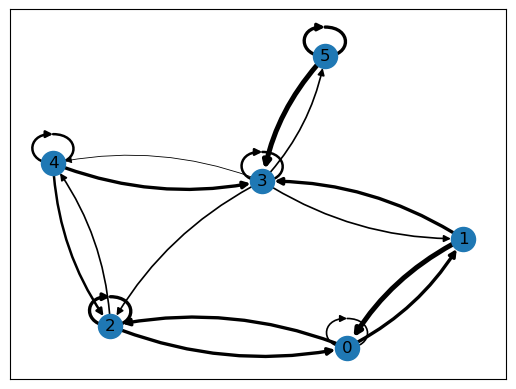

In [36]:
import networkx as nx

num_states = 6
transition_P = np.array([[0.2,0.4,0.4,  0,  0,  0],
                         [0.6,  0,  0,0.4,  0,  0],
                         [0.4,  0,0.4,  0,0.2,  0],
                         [  0,0.2,0.2,0.3,0.1,0.2],
                         [  0,  0,0.3,0.4,0.3,  0],
                         [  0,  0,  0,0.6,  0,0.4]])

def draw_transition_graph(P):
    # construct a directed graph directly from the matrix
    graph = nx.DiGraph(P)        
    # draw it in such a way that edges in both directions are visible and have appropriate width
    nx.draw_networkx(graph,connectionstyle='arc3, rad = 0.15',width=[6*P[u,v] for u,v in graph.edges()])
    
draw_transition_graph(transition_P)

## Markov Chain Monte Carlo via Metropolis-Hastings

The Metropolis-Hastings algorithm generates a Markov chain as follows. Given the state $x$, possible next states $y$ are distributed as $Q(x,y)$. This new state is accepted with probability $\displaystyle \alpha(x,y)=\text{min}(1,\frac{Q(y,x)\pi(y)}{Q(x,y)\pi(x)})$ where $\pi(z)$ is the distribution we wish to simulate. __This Markov chain can be shown to satisfy detailed balance, and thus approach the distribution $\pi(x)$.__ 

Taking $Q(x,y)=Q(y,x)$ simplies the acceptance rate. For simplicity, we will take $Q(x,y)$ to be independent of $x$ and uniform on $y$ - totally "uninformed". Finally, for the Gibbs distribution (Ising model) we have $\alpha=\text{min}\{1,\exp(-\beta \Delta E))\}$. This probabiltiy can be understood by generating a variable $x \sim \text{U}(0,1)$ and accepting the new configuration if $x<\alpha$.

For nearest neighbor interactions, the computation of $\Delta E$ from flipping $s_i$ only requires the nearest neighbor of $s_i$. Roughly, we have the expression $\Delta E = -2 (-J)\, s_i *$ neighbors. To convince yourself, imagine all spins taking $+1$. Flipping a single spin amounts to flipping the signs of the 4 bonds with its neighbors.

# Metropolis algorithm and trace plots

In [13]:
import numpy as np
import matplotlib.pylab as plt
from time import time

In [14]:
J = 1 # J can be absorbed into other parameters

In [15]:
def coldstart(L): 
    ''' LxL Matrix full of aligned spins with s = +1 '''
    return np.ones((L,L)) 

def hotstart(L): 
    ''' LxL Matrix of random spin '''
    return np.random.choice([-1,1],size=(L,L))

def antialigned(L):
    ''' LxL Checkerboard (Using Timothy Budds code - only produces 2d lattice)'''
    if L % 2 == 0:
        return np.tile([[1,-1],[-1,1]],(L//2,L//2))
    else:
        return np.tile([[1,-1],[-1,1]],((L+1)//2,(L+1)//2))[:L,:L]

In [16]:
def plot_ising(M, ax, title):
    ax.matshow(M,vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [17]:
def Metropolis_update(Latt, beta, H, N_iterations ):
    J = 1
    L = len(Latt)
    
    m = np.sum(Latt) # the magnetization
    
    e = 0
    for i in range(L):
        for j in range(L):
            # move through lattice and compute s_i * neighbors
            # this double counts bounds, so divide by 2 afterwards
            e += -J*Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                  + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
    e = e/2 - H*m
    
    trace=np.zeros((N_iterations,2)) # trace of energy and magnetization
    
    for s in range(N_iterations):
        # choose a random spin to flip - convince youself of the dE expression, do it by hand for a small lattice
        i, j = np.random.randint(0, L, 2)
        de = -2 * (-J) * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                            + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
        de = de + 2*H*Latt[i,j]

        if np.random.rand() < np.exp(-beta*de):
            Latt[i,j] *= -1 # flip the spin if random # < exp(-\beta de)
            e += de
            m += 2*Latt[i,j]
        
        trace[s] = [m,e]
    
    return trace

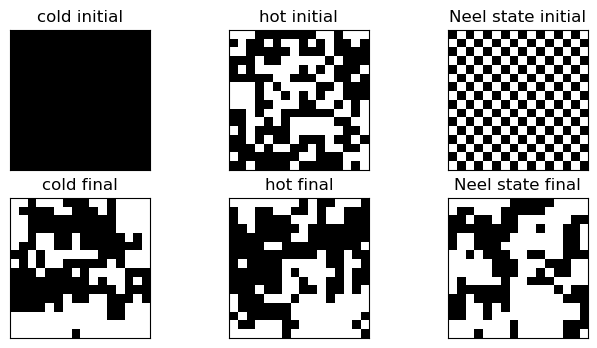

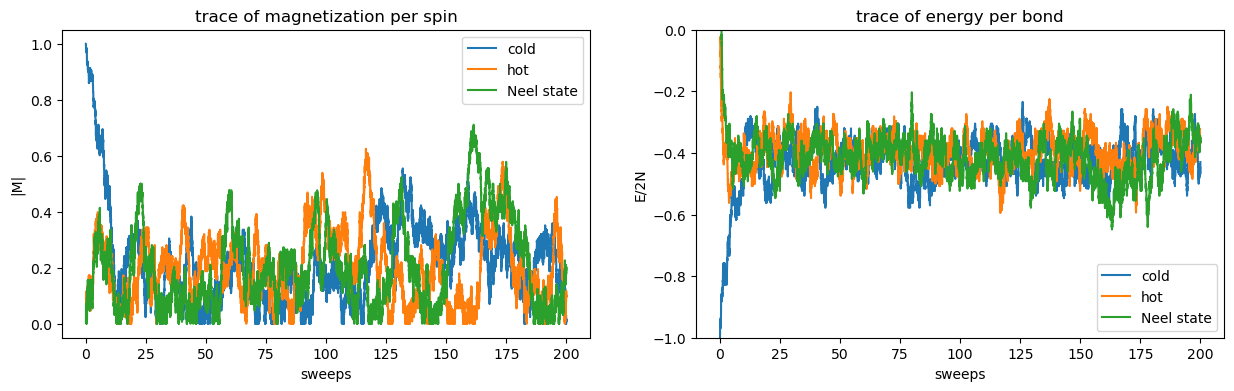

In [42]:
## Compute a Metropolis update for 200 updates per spin on a 16x16 lattice
## Use a variety of initial conditions to ensure convergence as well as get an idea of equilibriation time
## Code below is adapted from Timothy Budd

L = 16
N_sites = L**2

N_iterations = 200*N_sites

T,H = 3,0
beta = 1/T

initials = [coldstart, hotstart, antialigned]
labels = ["cold", "hot", "Neel state"]
num_ax = len(labels)

# Traces will contain {{e list, m list}, .., } for each initial condition
traces = []

# plot spin lattices for given initial and final configurations
fig, ax = plt.subplots(2, num_ax, figsize=(8,4))

for i, init in enumerate(initials):
    M = init(L)
    
    plot_ising(M,ax[0][i],labels[i]+" initial")
    
    traces.append(Metropolis_update(M, beta, H, N_iterations))
    
    plot_ising(M,ax[1][i],labels[i]+" final")
plt.show()

# plot magnetization and energy traces
fig, ax = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(N_iterations)/N_sites

for i,init in enumerate(initials):
    ax[0].plot(xrange, np.abs(traces[i][:,0])/N_sites)
    ax[1].plot(xrange, traces[i][:,1]/(2*N_sites))
    
[ ax[s].legend(labels) for s in [0,1] ]
[ ax[s].set_xlabel("sweeps") for s in [0,1] ]
ax[0].set_ylabel("|M|")
ax[1].set_ylabel("E/2N")

ax[1].set_ylim(-1,0)
ax[0].title.set_text("trace of magnetization per spin")
ax[1].title.set_text("trace of energy per bond")

## The Wolff Algorithm

The Wolff algortihm is a single cluster update algorithm. It takes a randon spin, forms a single cluster by joining neighboring spins with $p = 1 -e^{-2\beta J}$, then flips this cluster. There is a nice algorithm for constructing this cluster, apparently named a painting algorithm, which flips every spin as it is put into the cluster, automatically ensuring each spin is visited once.

__Needs:__
1. Write up how to implement for non-zero H. Detailed balance requires cluster is flipped with a probablity...
2. Incorporate efficient energy and magnetization traces

In [18]:
## Below is code adapted from Timothy Budd - only works for H=0

rng = np.random.default_rng()

def neighboring_sites(s,L):
    '''Return the coordinates of the 4 sites adjacent to s on an LxL lattice.'''
    return [((s[0]+1)%L,s[1]),((s[0]-1)%L,s[1]),(s[0],(s[1]+1)%L),(s[0],(s[1]-1)%L)]

def Wolff_update(Latt, beta, H, N_iterations ):
    J = 1
    L = len(Latt)
    p_add = 1 - np.exp(-2*beta)
    
    trace = np.zeros((N_iterations,2)) # trace of energy and magnetization
    
## Below is code for non-zero H $$

#     for s in range(N_iterations):
#         i, j = np.random.randint(0, L, 2)
#         proposal = Latt.copy()
#         seed = tuple([i,j])
#         spin = proposal[seed]
#         proposal[seed] = -spin
#         cluster_size = 1
#         unvisited = [seed]
#         while unvisited:
#             site = unvisited.pop()
#             for nbr in neighboring_sites(site,L):
#                 if proposal[nbr] == spin and rng.uniform() < p_add:
#                     proposal[nbr] = -spin
#                     unvisited.append(nbr)
#                     cluster_size += 1
        
#         de_h = 2*H*cluster_size
        
#         if np.random.rand() < min(1, np.exp(-beta * de_h )):
#             Latt = proposal

## The computation of energy and magnetization traces needs to be improved 

    for s in range(N_iterations):
        i, j = np.random.randint(0, L, 2)
        seed = tuple([i,j])
        spin = Latt[seed]
        Latt[seed] = -spin
        cluster_size = 1
        unvisited = [seed]
        while unvisited:
            site = unvisited.pop()
            for nbr in neighboring_sites(site,L):
                if Latt[nbr] == spin and rng.uniform() < p_add:
                    Latt[nbr] = -spin
                    unvisited.append(nbr)
                    cluster_size += 1
            
        m = np.sum(Latt) # the magnetization
        
        e = 0
        for i in range(L):
            for j in range(L):
                e += -J*Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                      + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
        e = e/2 - H*m
        
        trace[s] = [m,e]
        
        #print(Latt - coldstart(L))
        #print(Latt)
        #print(proposal)
    
    return trace

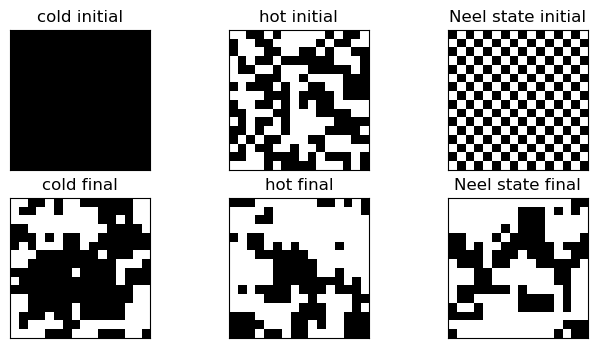

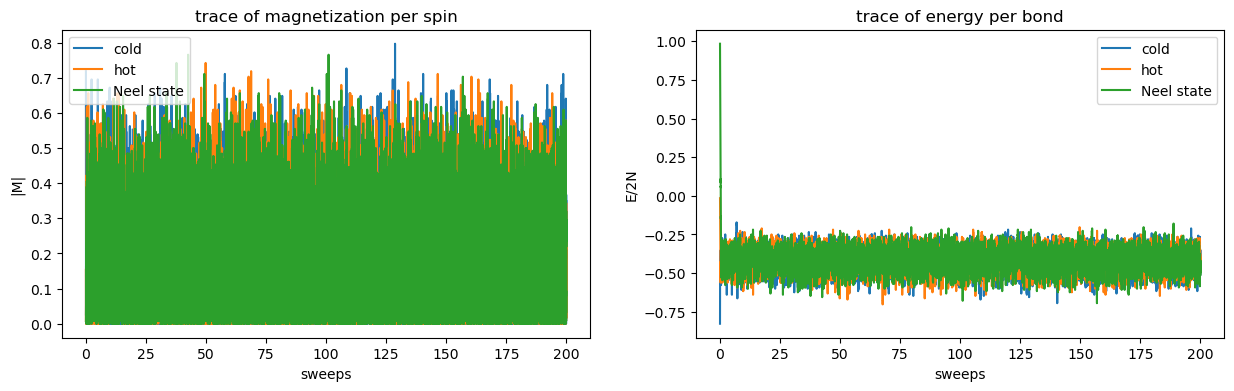

In [22]:
## Compute a Wolff update for 200 updates per spin on a 16x16 lattice
## Use a variety of initial conditions to ensure convergence as well as get an idea of equilibriation time
## Code below is adapted from Timothy Budd

L = 16
N_sites = L**2

N_iterations = 200*N_sites

T,H = 3,0
beta = 1/T

initials = [coldstart, hotstart, antialigned]
labels = ["cold", "hot", "Neel state"]
num_ax = len(labels)

# Traces will contain {{e list, m list}, .., } for each initial condition
traces = []

# plot spin lattices for given initial and final configurations
fig, ax = plt.subplots(2, num_ax, figsize=(8,4))

for i, init in enumerate(initials):
    M = init(L)
    
    plot_ising(M, ax[0][i], labels[i]+" initial")
    
    traces.append(Wolff_update(M, beta, H, N_iterations))
    
    plot_ising(M, ax[1][i], labels[i]+" final")
plt.show()

# plot magnetization and energy traces
fig, ax = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(N_iterations)/N_sites

for i,init in enumerate(initials):
    ax[0].plot(xrange, np.abs(traces[i][:,0])/N_sites)
    ax[1].plot(xrange, traces[i][:,1]/(2*N_sites))
    
[ ax[s].legend(labels) for s in [0,1] ]
[ ax[s].set_xlabel("sweeps") for s in [0,1] ]
ax[0].set_ylabel("|M|")
ax[1].set_ylabel("E/2N")

# ax[1].set_ylim(-1,0)
ax[0].title.set_text("trace of magnetization per spin")
ax[1].title.set_text("trace of energy per bond")

In [19]:
def cluster_flip(state,seed,p_add):
    L = len(state)
    spin = state[seed]
    state[seed] = -spin
    cluster_size = 1
    unvisited = [seed]
    while unvisited:
        site = unvisited.pop()
        for nbr in neighboring_sites(site,L):
            if state[nbr] == spin and rng.uniform() < p_add:
                state[nbr] = -spin
                unvisited.append(nbr)
                cluster_size += 1
    return cluster_size
                
def wolff_cluster_move(state, p_add):
    L = len(state)
    seed = tuple(rng.integers(0, L, 2))
    return cluster_flip(state,seed,p_add)

def wolff_update(state, p_add):
    L = len(state)
    seed = tuple(rng.integers(0, L, 2))
    return cluster_flip(state,seed,p_add)

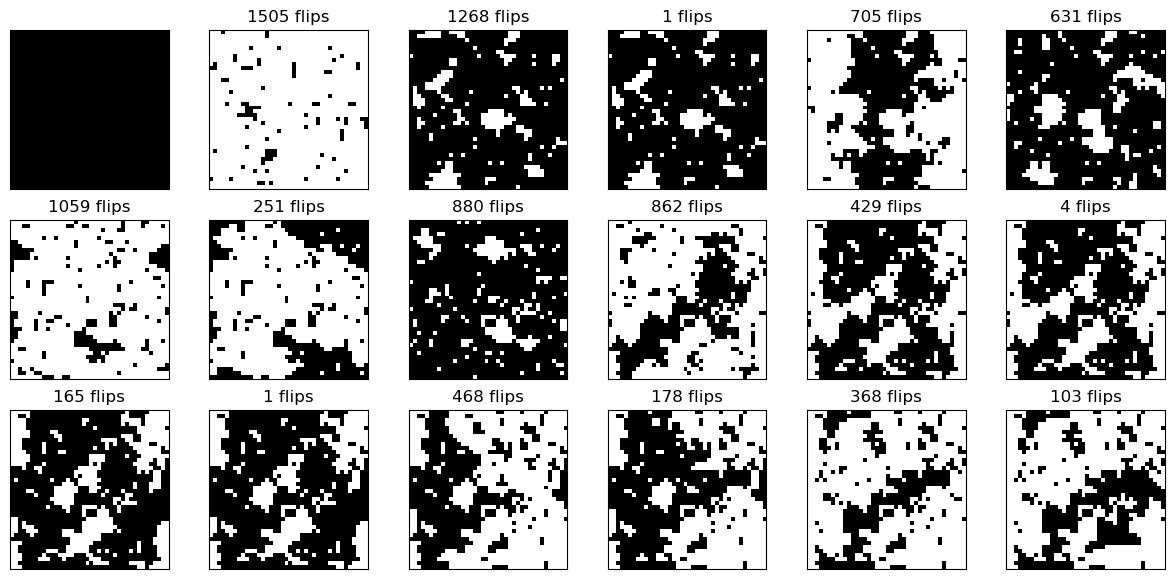

In [24]:
L = 40
temperature = 2.4
p_add = 1 - np.exp(-2/temperature)
config = coldstart(L)
fig, axs = plt.subplots(3,6,figsize=(15,7))
flips = 0
for axrow in axs:
    for ax in axrow:
        plot_ising(config,ax,"{} flips".format(flips) if flips > 0 else "")
        flips = wolff_cluster_move(config,p_add)

In [25]:
def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)

def run_ising_wolff_mcmc(state,p_add,n):
    '''Run n Wolff moves on state and return total number of spins flipped.'''
    total = 0
    for _ in range(n):
        total += wolff_cluster_move(state,p_add)
    return total

def sample_autocovariance(x,tmax):
    '''Compute the autocorrelation of the time series x for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/len(x) 
                     for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than 
    autocov[0]/e or the length of autocov if none are smaller.'''
    smaller = np.where(autocov < np.exp(-1)*autocov[0])[0]
    return smaller[0] if len(smaller) > 0 else len(autocov)

width = 20
nsites = width*width
temperatures = np.linspace(1.5,3.5,13)
equil_moves = 200
autocorr_moves = 2400
tmax = 70

autocorr_times = []

for temp in temperatures:
    p_add = 1 - np.exp(-2/temp)
    state = coldstart(width)
    run_ising_wolff_mcmc(state,p_add,equil_moves)
    total_flips = 0
    trace = np.zeros(autocorr_moves)
    for i in range(autocorr_moves):
        total_flips += run_ising_wolff_mcmc(state,p_add,1)
        trace[i] = compute_magnetization(state)
    autocov = sample_autocovariance(np.abs(trace),tmax)
    time = find_correlation_time(autocov)
    autocorr_times.append((time,total_flips/(autocorr_moves)))

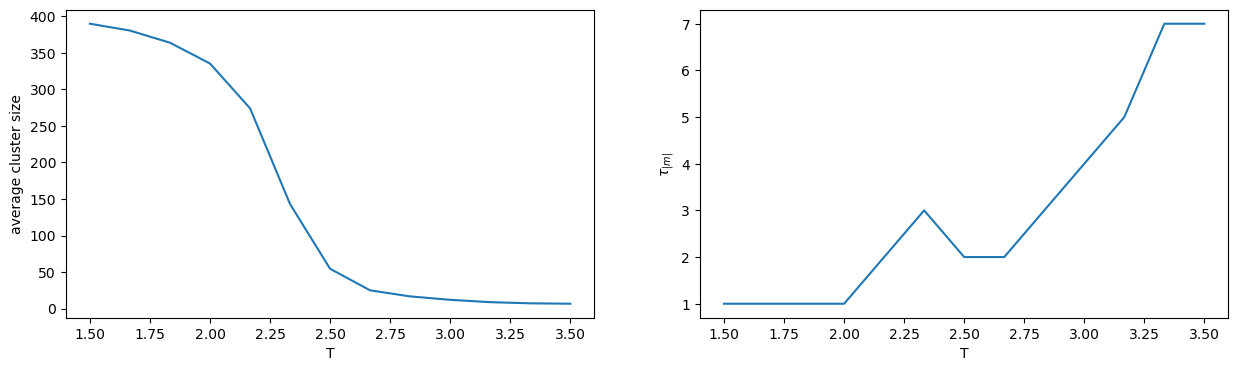

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(temperatures,[av_size for tau,av_size in autocorr_times])
ax[0].set_xlabel("T")
ax[0].set_ylabel("average cluster size")
ax[1].plot(temperatures,[tau for tau,av_size in autocorr_times])
ax[1].set_xlabel("T")
ax[1].set_ylabel(r"$\tau_{|m|}$")
plt.show()

# The Heatbath Algorithm

Instead of flipping a spin based off the change in energy, flip it based off a thermal equiblibrium distribution. Given that $\text{Prob}(s_i=+1) \propto e^{-\beta E_{i,+}}$:
$$\text{Prob}(s_i=+1) =\frac{e^{-\beta E_{i,+}}}{e^{-\beta E_{i,+}}+e^{-\beta E_{i,-}}}$$
The local energies for the spin at site $i$ are given by
$$E_{i,+} = -J s_i \sum neighbors = -J \sum neighbors$$
$$E_{i,-} = J \sum neighbors$$
Then we have that 
$$ \text{Prob}(s_i=+1) =\frac{1}{1+e^{-2\beta \sum neighbors}} $$
$$ \text{Prob}(s_i=-1) =\frac{1}{1+e^{\, 2\beta \sum neighbors}} $$
or for non-zero external fields
$$ \text{Prob}(s_i=+1) =\frac{1}{1+e^{-2\beta (\sum neighbors+H)}} $$
$$ \text{Prob}(s_i=-1) =\frac{1}{1+e^{\,2\beta (\sum neighbors+H)}} $$

Since if the spin is $+1$, then $\Delta E = 2*\sum neighbors$; however, if the spin is $-1$, then $\Delta E = -2*\sum neighbors$. So if spin is up, we flip with probablity $(1+e^{\beta \Delta E})^{-1}$. And if spin is down, we flip with probablity $(1+e^{\beta \Delta E})^{-1}$.

Ultimately, we have 
$$\text{Prob}(flip) =\frac{1}{1+e^{\beta \Delta E}} $$

In [20]:
def Heatbath_update(Latt, beta, H, N_iterations ):
    J = 1
    L = len(Latt)
    
    m = np.sum(Latt) # the magnetization
    
    e = 0
    for i in range(L):
        for j in range(L):
            # move through lattice and compute s_i * neighbors
            # this double counts bounds, so divide by 2 afterwards
            e += -J*Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                  + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
    e = e/2 - H*m
    
    trace=np.zeros((N_iterations,2)) # trace of energy and magnetization
    
    for s in range(N_iterations):
        # choose a random spin to flip - convince youself of the dE expression, do it by hand for a small lattice
        i, j = np.random.randint(0, L, 2)
        de = -2 * (-J) * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                            + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
        de = de + 2*H*Latt[i,j]

        if np.random.rand() < 1/(1+np.exp(beta*de)):
            Latt[i,j] *= -1 # flip spin and increment energy and magnetization
            e += de
            m += 2*Latt[i,j]
        
        trace[s] = [m,e]
    
    return trace

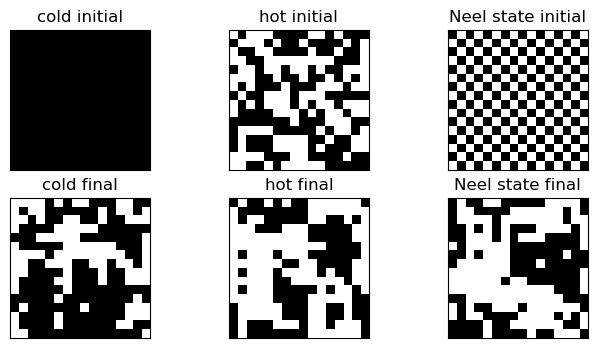

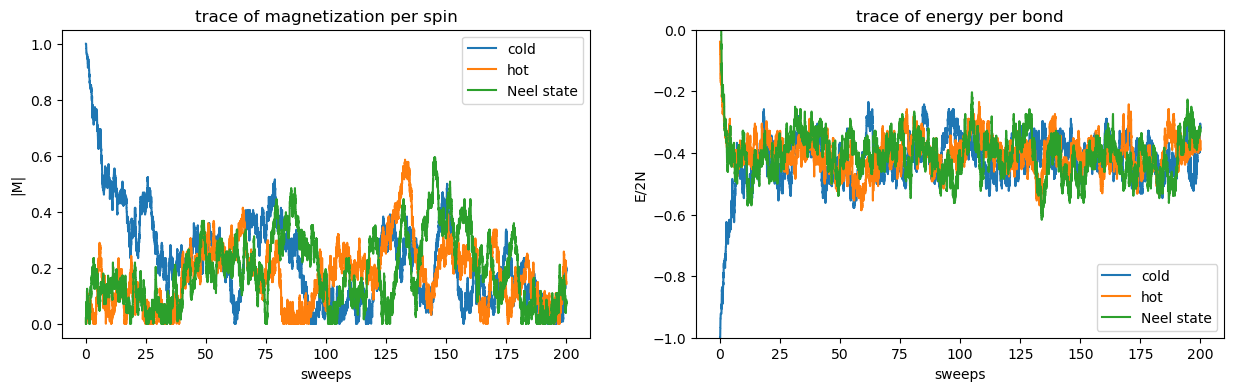

In [28]:
## Compute a Heatbath update for 200 updates per spin on a 16x16 lattice
## Use a variety of initial conditions to ensure convergence as well as get an idea of equilibriation time
## Code below is adapted from Timothy Budd

L = 16
N_sites = L**2

N_iterations = 200*N_sites

T,H = 3,0
beta = 1/T

initials = [coldstart, hotstart, antialigned]
labels = ["cold", "hot", "Neel state"]
num_ax = len(labels)

# Traces will contain {{e list, m list}, .., } for each initial condition
traces = []

# plot spin lattices for given initial and final configurations
fig, ax = plt.subplots(2, num_ax, figsize=(8,4))

for i, init in enumerate(initials):
    M = init(L)
    
    plot_ising(M,ax[0][i],labels[i]+" initial")
    
    traces.append(Heatbath_update(M, beta, H, N_iterations))
    
    plot_ising(M,ax[1][i],labels[i]+" final")
plt.show()

# plot magnetization and energy traces
fig, ax = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(N_iterations)/N_sites

for i,init in enumerate(initials):
    ax[0].plot(xrange, np.abs(traces[i][:,0])/N_sites)
    ax[1].plot(xrange, traces[i][:,1]/(2*N_sites))
    
[ ax[s].legend(labels) for s in [0,1] ]
[ ax[s].set_xlabel("sweeps") for s in [0,1] ]
ax[0].set_ylabel("|M|")
ax[1].set_ylabel("E/2N")

ax[1].set_ylim(-1,0)
ax[0].title.set_text("trace of magnetization per spin")
ax[1].title.set_text("trace of energy per bond")

# The Wang-Landau Algorithm for the denisty of states

__Rough Sketch:__
A non-Markovian process to generate the density of states for systems with a finite number of discrete energy levels. This is a random walk in energy space.
- To begin, initialize $g(E_i) = 1 $ and $h(E_i)=0$  $\forall i$ and take the lattice to be, say, aligned. Set $f = e^1$
    1. Current energy is $E_i$. Choose a random spin and deteremine and compute the energy change, so $E_j=E_i+\Delta E$.
    2. Accept new state with probablity $\alpha = \text{min}(1, \, \frac{g(E_i)}{g(E_j)} )$.
    3. If accepted, $g(E_j) \to  f \times g(E_i)$ and $h(E_i)=h(E_i)+ 1$
    4. Repeated procedure until, say 20% flatness, min$(h(E))> 0.8$ mean$(h(E))$ and max$(h(E))< 1.2$ mean$(h(E))$.
        - If flat, take $f \to f^{1/2}$ ( or other reduction ), reset the histrogram to 0s, and return to step one.
            - Do not change the denisty of states!
        - If $f < f_{min} = 1+10^{-8}$, terminate procedure. ( f_min can be altered as well.)
- In practice, use the log density of states.
- Return the relative density of states. Use known results to normalize the density of states. For instance, $g(E = -2NJ)=2.$

In [21]:
def E_list_gen(L):
    ''' Generates list of energies for even L '''
    if L % 2 != 0:
        raise ValueError("This list generation only works for even side lengths")
        
    E_list=[-2*L**2 + 4*k for k in range(0,L**2+1)]
    E_list.pop(1)
    E_list.pop(-2)
    E_list=np.array(E_list)  # energy states = N-1 
    
    # Emax = 2*L**2
    # [(e+Emax)//4 for e in E_list]
    
    return E_list

In [22]:
def Wang_Landau_update(L, N_sweeps = 10**3, flatness = .2, logf = 1, fmod = 1/2, f_criteria = 1e-8):
    # Initialize using fully aligned state
    E_list = E_list_gen(L)
    lngE_list = np.zeros_like(E_list, dtype = float)
    hE_list = np.zeros_like(E_list, dtype = int)
    state = coldstart(L)
    e1 = -2*L**2
    index1 = np.argwhere( E_list == e1)[0,0]

    while logf > f_criteria:
        # reset the histogram each iteration
        hE_list.fill(0)
        iteration = 0
        # run while loop while not(h_min < .8 h_mean and h_max > 1.2 h_mean)
        while np.min(hE_list) <= (1-flatness)*np.mean(hE_list) or np.max(hE_list) >= (1+flatness)*np.mean(hE_list):
            for s in range(N_sweeps*L**2):                
                i,j = rng.integers(0, L, 2)
                de = 2*state[i,j]*( state[i, (j+1)%L] + state[i, (j-1)%L] + 
                                   state[(i+1)%L, j] + state[ (i-1)%L, j] )
                e2 = e1 + de
                index2 = np.argwhere( E_list == e2)[0,0]
                
                if np.random.random() < np.exp(lngE_list[index1]-lngE_list[index2]):
                    state[i,j] *= -1
                    e1 = e2
                    index1 = index2
                else:
                    index1 = index1
                    
                lngE_list[index1] += logf
                hE_list[index1] += 1 
                iteration += 1
                
        print(" log(f) = ", logf, " and sweeps =", iteration//L**2)
        logf *= 1/2

    return lngE_list, hE_list

In [123]:
t0 = time()
L = 8
lngE_list, hE_list = Wang_Landau_update(L = L)
print("Computation time = ", time()-t0)

 log(f) =  1  and sweeps = 1000
 log(f) =  0.5  and sweeps = 1000
 log(f) =  0.25  and sweeps = 3000
 log(f) =  0.125  and sweeps = 2000
 log(f) =  0.0625  and sweeps = 3000
 log(f) =  0.03125  and sweeps = 2000
 log(f) =  0.015625  and sweeps = 2000
 log(f) =  0.0078125  and sweeps = 3000
 log(f) =  0.00390625  and sweeps = 4000
 log(f) =  0.001953125  and sweeps = 4000
 log(f) =  0.0009765625  and sweeps = 5000
 log(f) =  0.00048828125  and sweeps = 9000
 log(f) =  0.000244140625  and sweeps = 4000
 log(f) =  0.0001220703125  and sweeps = 11000
 log(f) =  6.103515625e-05  and sweeps = 27000
 log(f) =  3.0517578125e-05  and sweeps = 5000
 log(f) =  1.52587890625e-05  and sweeps = 11000
 log(f) =  7.62939453125e-06  and sweeps = 15000
 log(f) =  3.814697265625e-06  and sweeps = 35000
 log(f) =  1.9073486328125e-06  and sweeps = 12000
 log(f) =  9.5367431640625e-07  and sweeps = 7000
 log(f) =  4.76837158203125e-07  and sweeps = 8000
 log(f) =  2.384185791015625e-07  and sweeps = 45000


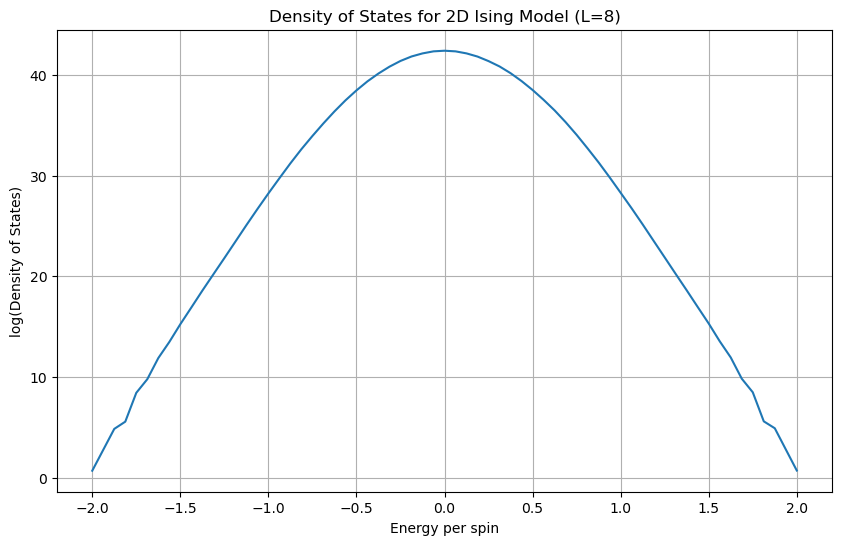

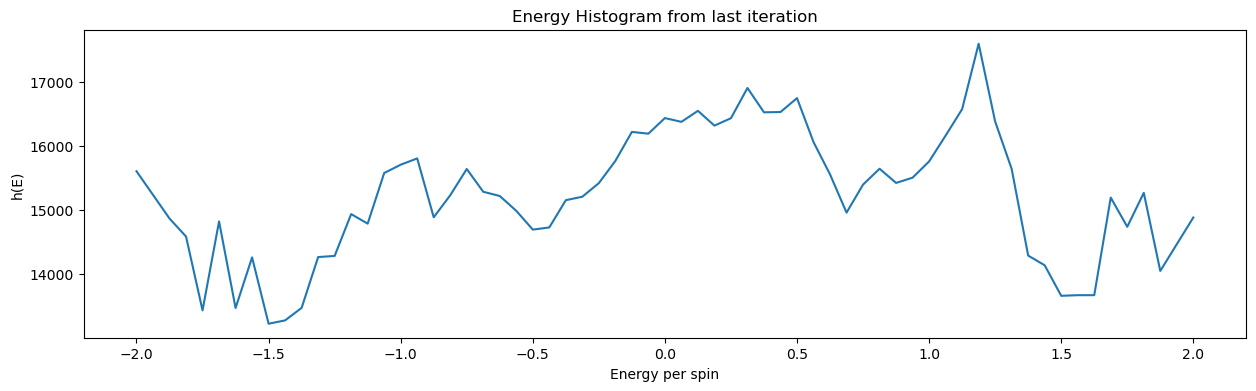

In [124]:
lngE_list_norm = lngE_list - lngE_list[0]+np.log(2)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(E_list_gen(L)/L**2,lngE_list_norm)
ax.set_xlabel('Energy per spin')
ax.set_ylabel('log(Density of States)')
plt.title(f'Density of States for 2D Ising Model (L={L})')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(E_list_gen(L)/L**2,hE_list)
ax.set_xlabel("Energy per spin")
ax.set_ylabel("h(E)")
plt.title(f'Energy Histogram from last iteration')

plt.show()

## Alternative class definition

In [125]:
def plot_dos_prob_e(model, temperatures):
    fig,ax = plt.subplots(1,2, figsize=(12, 5))
    
    e_range = model.energy_range/(2*model.L**2)

    ax[0].plot(e_range, model.dos)
    ax[0].set_xlabel('Energy per spin')
    ax[0].set_ylabel('log(Density of States)')
    ax[0].set_title(f'Density of States for 2D Ising Model (L={model.L})')

    for t in temperatures:
        prob_energy = model.calculate_prob_energy(t)
        ax[1].plot(e_range, prob_energy)
    ax[1].set_xlabel('Energy per spin')
    ax[1].set_ylabel('Prob(Energy)')
    ax[1].set_title(f'Energy Distribtuion for 2D Ising Model (L={model.L})')

    plt.show()

In [126]:
class Wang_Landau_2DIsing:
    # Code works only for H =0 
    def __init__(self, L, J=1):
        self.L = L
        self.J = J
        self.lattice = np.random.choice([-1, 1], size=(L, L))
        self.energy_range = self.E_list_gen()
        self.mag_range = np.arange(-L**2,L**2+1,2)
        #self.dos = np.zeros_like(self.energy_range, dtype=float)
        self.dos = np.zeros((L**2-1,L**2+1), dtype=float)
        self.histogram = np.zeros_like(self.dos, dtype=int)
        self.logf = 1
        self.total_energy = self.calculate_energy()
        self.total_mag = np.sum(self.lattice)
    
    def E_list_gen(self):
        ''' Generates list of energies for even L '''
        if self.L % 2 != 0:
            raise ValueError("This list generation only works for even side lengths")

        E_list=[-2*self.L**2 + 4*k for k in range(0,self.L**2+1)]
        E_list.pop(1)
        E_list.pop(-2)
        E_list=np.array(E_list)  # number of energy states = N-1

        return E_list
        
    def calculate_energy(self):
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                energy += -self.J * self.lattice[i, j] * (
                    self.lattice[(i+1)%self.L, j] + 
                    self.lattice[i, (j+1)%self.L] )
        return energy
    
    def flip_spin(self):
        i, j = np.random.randint(0, self.L, 2)
        delta_E = 2 * self.J * self.lattice[i, j] * (
            self.lattice[(i+1)%self.L, j] + 
            self.lattice[(i-1)%self.L, j] + 
            self.lattice[i, (j+1)%self.L] + 
            self.lattice[i, (j-1)%self.L] )
        return i, j, delta_E
    
    def calculate_prob_energy(self, T=1):
        partition_function = np.sum([ np.exp(g-e/T) for g,e in zip(self.dos, self.energy_range) ])
        return [ 1/partition_function*np.exp(g-e/T) for g,e in zip(self.dos, self.energy_range) ]


    def run_zero_h(self, logf_min = 1e-8, flatness_criterion = .8, N_sweeps = 1e2):
        # Surprsingly, checking every iteration is faster for L=8, haven't checked other sizes...
        self.dos = np.zeros_like(self.energy_range, dtype=float)
        self.histogram = np.zeros_like(self.energy_range, dtype=int)
        
        index1 = np.argwhere( self.energy_range == self.total_energy)[0,0]
        while self.logf > logf_min:
            iteration = 0
            self.histogram.fill(0)
            while np.min(self.histogram) <= flatness_criterion * np.mean(self.histogram):
                for s in range(int(N_sweeps*self.L**2)):
                    i, j, delta_E = self.flip_spin()
                    new_energy = self.total_energy + delta_E
                    index2 = np.argwhere( self.energy_range == new_energy)[0,0]

                    if (np.random.random() < np.exp(self.dos[index1] - self.dos[index2])):
                        self.lattice[i, j] *= -1
                        self.total_energy = new_energy
                        index1 = index2
                    else:
                        index1 = index1

                    self.dos[index1] += self.logf
                    self.histogram[index1] += 1
                    iteration += 1
                
            #print(f"ln(f) = {self.logf}", "and sweeps = ", iteration//self.L**2)
            self.logf *= 1/2
        
        #self.dos -= self.dos.min()
        self.dos -= (self.dos[0]-np.log(2))
        return self.energy_range, self.dos

Computation time =  22.071726083755493


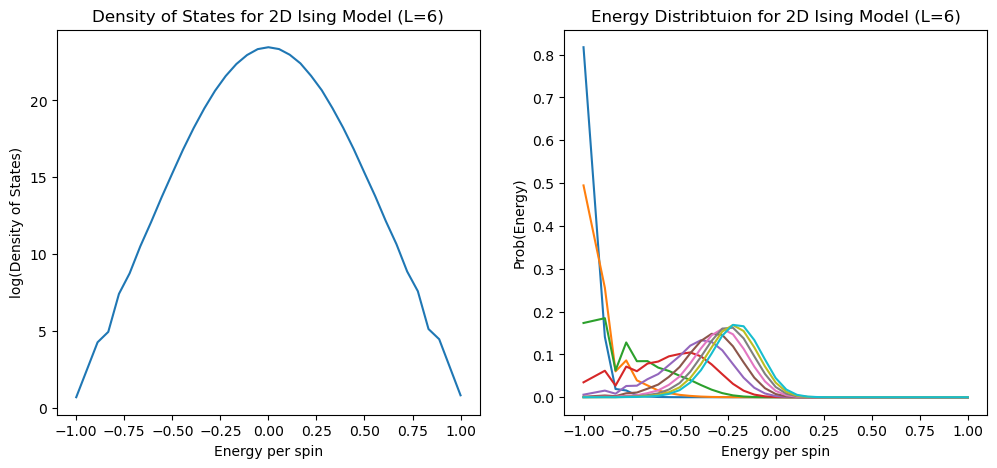

In [127]:
# Run the simulation
L = 6
model = Wang_Landau_2DIsing(L)
t0 = time()
energy_range, dos = model.run_zero_h()
print("Computation time = ", time()-t0)

temperatures = np.linspace(1.5,5,10)
plot_dos_prob_e(model,temperatures)

# Benchmarking against exact results

By generating the set of spin configurations for a given N and computing their energies and degeneracies, one can construct the exact partition function $\mathcal{Z}_N(\beta)$. From this function, one can recover all the physics we are interested in. We only attempt to do so for small $N$, specficially $N \in \{2,3,4\}$. Simple things to compare are the energy space Monte Carlo histrograms with the exact probabiltiy distribution given by 
\begin{eqnarray}
p(E_k)=\mathcal{Z}^{-1}\,\Omega(E_k)\,\exp(-\beta E_k)
\end{eqnarray}
Other simple measurements are the average energy and magnetziation vs temperature.

## Effective sample size and error of observable averages

Given the central limit theorem, $\bar{X}_n \sim \mathcal{N}(\mu,\frac{\sigma^2}{n})$, Monte Carlo averages are eexpected to be normalliy distrubted. We can then put bounds on the results of our Monte Carlo averages using $95\%$ confidence intervals: $\displaystyle \bar{X} \pm 1.96 \frac{\sigma}{\sqrt{n}}$. But, this only holds for a set of $n$ uncorrelated observations. For correlated observations, we take $n \to n_{\text{eff}}$ where the autocorrelation length reduces the effective sample size. 

To account for the correlations, one can either determine how to compute $n_{\text{eff}}$ or, do two MC runs - the first determines $\tau$, while the second takes sweeps large enough to encompass $\tau$ and produce uncorrelated observations (which can be checked by checking that $\tau \approx 1$ ).

But, we don't know $\sigma^2$. So, we estimate the variance using the sample variance (of $n-1$ degrees of freedom ) - $\sigma^2 \to s^2=\frac{1}{n-1}\sum_i \left( X_i-\bar{X} \right)^2$. Our new confidence intervals become 
$$\bar{X} \pm t_{\alpha/2} \, \frac{s}{\sqrt{n}}$$ 
where $\alpha=0.05$ and $t_{\alpha/2}$ is defined such that Prob$(t < t_{\alpha/2})=\alpha/2$ via the $t_{\nu=n-1}$-distribution. Note that for very large sample sizes, $n>>1$, we have $t_{\alpha/2}\approx 1.96$ for $\alpha=.05$. This will be the case for our Monte Carlo results, yielding
$$\bar{X} \pm 1.96 \, \frac{s}{\sqrt{n}}$$ 

### Effect of autocorrelations:

The presence of autocorrelations within a sample adds a multiplicative factor to the variance of the sample mean, Var$(\bar{X}) \approx 2*\tau_{\text{exp}}\frac{s^2}{n}$. Yielding the interval
$$\bar{X} \pm 1.96 * \sqrt{\frac{2\tau_{\text{exp}}\,s^2}{n}}$$ 
Since measurements are a computational expense and somewhat inefficient in the presence of autocorrelations, one can instead measure every handful of sweeps $n$ such that $n \le \tau$. The error associated with measurements from the two sets should be roughly equivalent - a trade off between sample size and correlation length.

## Errors of non-linear functions of random variables:

1. Batching, Jackknife, Bootstrap

## Computing autocorrelation time

Some things need to be said about autocorrelation. Due to the procedure for configuration generation, the configurations are not statistically independent. The degree to which nearby configurations are correlated is measured by the correlation time. Two measures we explore are integrated and (more loosely) the exponential corrrelation times. Furthermore, the correlation time depends on system parameters. Near the Ising critical point, we expect $\tau$ to diverge for single-spin flip updates. Additionally, given the single spin nature of the Metropolis-Hastings algorithm, the number of steps required to generate an uncorrelated configuration should scale as a function of $N$.

A common definition of the population and sample autocovariance is 
\begin{eqnarray}
C(\tau)&=&\text{Cov}(X_t,X_{t+\tau}) \\
\hat{C}(\tau)&=&\frac{1}{(n-\tau)}\sum_{i=1}^{n-t}\left(X_i-\bar{X}\right)\left(X_{i+\tau}-\bar{X}\right)
\end{eqnarray}
We then use the normalized autocorrelation functions by using the fact that $C(0)=\sigma^2$ and similarly for the estimator $\hat{C}$. We define
\begin{eqnarray}
\rho(t)&=&\frac{C(t)}{C(0)}=\frac{C(t)}{\sigma^2} \\
\hat{\rho}(t)&=&\frac{\hat{C}(t)}{s^2}
\end{eqnarray}
where $s^2 \sim \frac{1}{n}$. We use two measures of the autocorrelation time:
\begin{eqnarray}
%%\tau_{int} &=& \frac{1}{t}\int_0^{\infty} \rho(t) \, dt \\
\tau_{int} &=& 1 +2 \sum_{n=0}^{\infty} \rho(t_n) \\
\tau_{\text{exp}} &=& -\text{inf}_t\{ t : \rho(t)<e^{-1} \}
\end{eqnarray}
For the exponential correlation time, we equivalently expect the form $ \displaystyle \rho(t) \sim e^{-t/\tau}$. Notice that we can define $\tau_{\text{int}}(t)$ by simply replacing integral upper limit with $t$.

A important point to make is that the correlation time does depend on the function of which we are taking expectations. However, theorectically they should all be related. We will look at the magnetization and the energy correlation times.

The following formulas are useful:
\begin{eqnarray}
\text{Var}\left( \bar{X}_n \right)&=&\frac{1}{n}\text{Var}(X)\left(1+\frac{2}{n}\sum_{i=1}^n\sum_{j>i }\frac{\text{Cov}(X_i,X_j)}{\text{Var}(X)} \right) \\
&=&\frac{1}{n}\text{Var}(X)\left(1+\frac{2}{n}\sum_{i=1}^n\sum_{j>i }\, \rho(X_i,X_j) \right) \\
&=&\frac{1}{n}\text{Var}(X)\left(1+2\sum_{t=1}^{n-1}\frac{n-t}{n} \rho(t) \right)
\end{eqnarray}
In the case of independent identically distributed variables, $\rho(t)=0$ and we recover the usual Var$\displaystyle (\bar{X})=\frac{\sigma^2}{n}$. The effect of autocorrelation reduces the _effective sample size_ - $n_{\text{eff}}=\frac{n}{\alpha}$ where $\alpha=\left(1+2\sum_{t=1}^{n-1}\frac{n-t}{n} \rho(t) \right)$. 

Ultimately, the correlation time measures the efficiency of an algorithm. We expect to see that the Wolff algortihm has a much smaller correlation time.

## Autocorrelation functions

In [23]:
import scipy

def auto_corr(x): ## scipy signal.correlate is signifcantly faster than 
    #                 numpy's correlate which is significantly faster than hand-made code
    l = len(x)
    avg = np.mean(x)
    var = np.var(x)
    x = [i-avg for i in x]
    #acov = np.correlate(x,x,"full")[l-1:]
    auto_covariance = scipy.signal.correlate(x,x,"full")[l-1:]
    return auto_covariance/(l*var)

def exp_corr_len(x):
    def comp(s):
        if s > np.exp(-1):
            return 0
        else:
            return 1
    partition = [comp(i) for i in x]
    return partition.index(1)  


def int_corr_time_set(x, t_lag): 
    ## Integrated corr time. Since auto_corrs are computed all at once, 
    ##   compute correlations time all at once
    l = len(x)
    avg = np.mean(x)
    var = np.var(x)
    x = [i-avg for i in x]
    auto_covariance = scipy.signal.correlate(x, x, "full")[l-1: ]
    #auto_covariance = np.correlate(x, x, "full")[l-1: ]
    auto_correlation = [ 1 + 2*np.sum(auto_covariance[:i+1])/(l*var)  for i in range(t_lag-1)]
    return np.array([1] + auto_correlation)

## N=4 energy histrograms, correlation length at $T=3,H=1$

Computation time = 16.084428787231445
Energy list:  [-48.0, -38.0, -32.0, -28.0, -26.0, -24.0, -22.0, -20.0, -18.0, -16.0, -14.0, -12.0, -10.0, -8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 26.0, 32.0]
Mag. corr. length:  1.75 , and E. corr. length:  1.6875
avg energy: E = -40.0807 +- 0.0269
mean energy: E = -39.9941
avg magnetization: E[|m|] = 0.8845 +- 0.0005


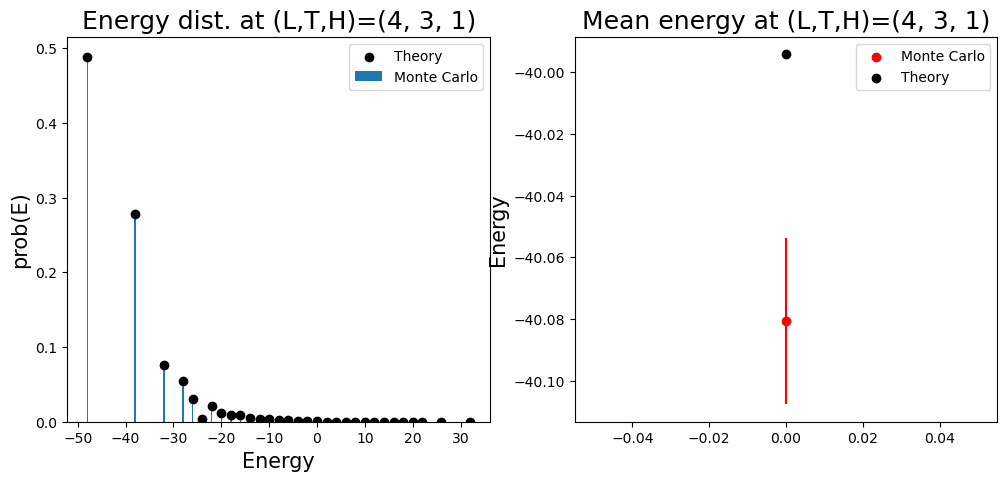

In [108]:
L,T,H = 4, 3, 1
beta = 1/T
N_sites = L**2
N_burnin = 400*N_sites
N_iterations = 10**5*N_sites

t0 = time()
trace = Metropolis_update(hotstart(L), beta, H, N_burnin + N_iterations)
trace = trace[N_burnin:]

Mag_data = np.abs(trace[:,0])/N_sites
l_m = exp_corr_len(auto_corr(Mag_data))/N_sites

E_data = trace[:,1]
l_e = exp_corr_len(auto_corr(E_data))/N_sites

## compute histrogram and exact probablities
elist = [Ham(M,H) for M in config_gen(L)]
eset = sorted(set(elist))
degeneracies = np.array([ (e, elist.count(e)) for e in eset])

partition_function = np.sum([np.exp(-1/T*e) for e in elist ])
prob_set = np.zeros_like(eset)
for i,e in enumerate(eset):
    j = np.where(degeneracies[:,0] == e)[0][0]
    degen = degeneracies[j][1]
    prob_set[i] = partition_function**(-1)*degen*np.exp(-1/T*e)

E_mean = np.sum( [e*p for e,p in zip(eset,prob_set)] )

E_data = np.round(E_data,5)  ## Rounding off errors induced by non-zero H. Not sure-fire but works for now

bars = np.array([list(E_data).count(e) for e in eset])/len(E_data)
E_avg = np.mean(E_data)
E_svar = 2*l_e*np.var(E_data, ddof=1)/len(E_data)
E_err = 1.96*np.sqrt(E_svar)

Mag_avg = np.mean(Mag_data)
Mag_svar = 2*l_m*np.var(Mag_data, ddof = 1)/len(Mag_data)
Mag_err = 1.96*np.sqrt(Mag_svar)

print("Computation time =", time()-t0)
print("Energy list: ", eset)
print("Mag. corr. length: ", l_m,", and E. corr. length: ",l_e)
print("avg energy: E = {:.4f} +- {:.4f}".format(*[E_avg,E_err]))
print("mean energy: E = {:.4f}".format(E_mean))
print("avg magnetization: E[|m|] = {:.4f} +- {:.4f}".format(*[Mag_avg,Mag_err]))
#print("mean magnetization: <E>={:.4f}".format(Mag_mean))

fig, ax = plt.subplots(1,2 , figsize=(12, 5))
ax[0].bar(eset, bars, width = .3, label="Monte Carlo")
ax[0].scatter(eset,prob_set, color = "black", label = "Theory") 
ax[0].legend()
ax[0].set_xlabel("Energy",fontsize = 15) 
ax[0].set_ylabel("prob(E)" ,fontsize = 15)
ax[0].set_title(f"Energy dist. at (L,T,H)={(L,T,H)}", fontsize=18)

ax[1].scatter([0],[E_avg], color="red", label=f"Monte Carlo") 
ax[1].scatter([0],[E_mean], color="black", label=f"Theory") 
ax[1].errorbar([0],[E_avg], yerr=E_err, linestyle="None", color='red')
ax[1].legend()
ax[1].set_ylabel("Energy" ,fontsize=15)
ax[1].set_title(f"Mean energy at (L,T,H)={(L,T,H)}", fontsize=18)
plt.show()

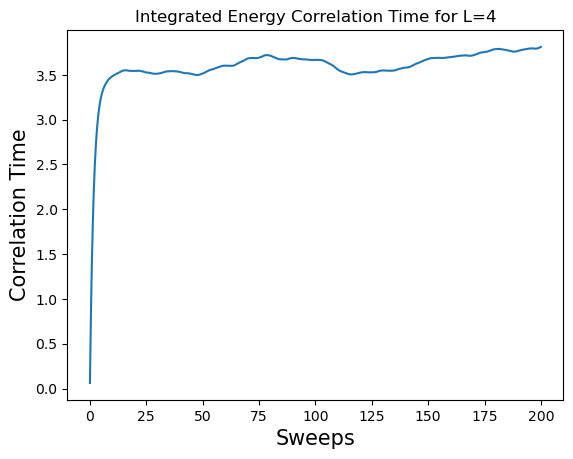

In [114]:
time_stop=200*N_sites
tau_set=int_corr_time_set(E_data,time_stop)/N_sites
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(time_stop)/N_sites,tau_set)
#ax.plot(range(time_stop),np_corr_time_set(E_data,time_stop), color="g") 
ax.set_xlabel("Sweeps",fontsize=15) 
ax.set_ylabel("Correlation Time" ,fontsize=15)
plt.title(f"Integrated Energy Correlation Time for L={L}")
plt.show()

# Autocorrelations for the Metropolis-Hastings algorithm:

In [259]:
L,T,H = 16, 3, 0
N_sites = L**2
N_burnin = 400*N_sites
N_iterations = 2*10**4*N_sites

t0 = time()
trace = Metropolis_update(hotstart(L), beta, H, N_burnin + N_iterations)
print("time:", time()-t0)

time: 37.513089179992676


In [260]:
t0 = time()
Mag_autocorr = auto_corr(trace[:,0])
E_autocorr = auto_corr(trace[:,1])
t1 = time()
print(f"Total computation time: {t1-t0}")

Total computation time: 2.0617339611053467


Magnetic correlation length is  12.88671875 , and Energy correlation length is 1.796875


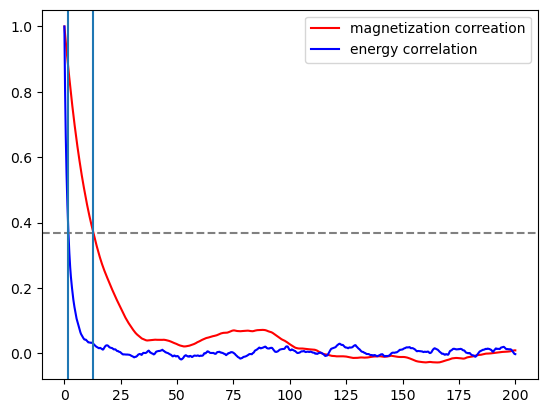

In [261]:
time_stop = 200*N_sites
l_m = exp_corr_len(Mag_autocorr[:time_stop])/N_sites
l_e = exp_corr_len(E_autocorr[:time_stop])/N_sites
print(f"Magnetic correlation length is ", l_m, r", and Energy correlation length is", l_e)

xrange = np.arange(time_stop)/N_sites
labels = ["magnetization correation", "energy correlation"]
fig, ax = plt.subplots(1,1)
ax.plot(xrange, Mag_autocorr[:time_stop], color="red")
ax.plot(xrange, E_autocorr[:time_stop], color="blue")
ax.axhline(np.exp(-1), linestyle='--', color='0.5')
ax.axvline(l_m)
ax.axvline(l_e)
plt.legend(labels)
plt.show()

In [266]:
Mag_corr_time_set = int_corr_time_set(trace[:,0], time_stop)
E_corr_time_set = int_corr_time_set(trace[:,1], time_stop)

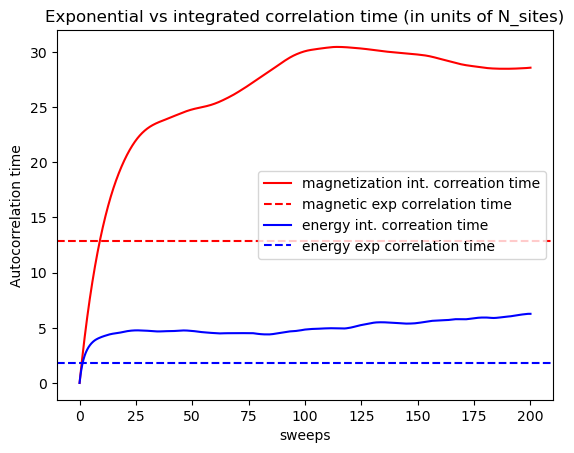

In [268]:
xrange = np.arange(time_stop)/N_sites
legend = ["magnetization int. correation time","magnetic exp correlation time", 
     "energy int. correation time","energy exp correlation time"]

fig, ax = plt.subplots(1,1)

ax.plot(xrange, Mag_corr_time_set/N_sites, color = "red")
ax.axhline(l_m, color = "red", linestyle="--")

ax.plot(xrange, E_corr_time_set/N_sites, color = "blue")
ax.axhline(l_e, color = "blue",linestyle = "--")

ax.set_xlabel("sweeps")
ax.set_ylabel("Autocorrelation time")
ax.title.set_text("Exponential vs integrated correlation time (in units of N_sites)")
plt.legend(legend)
ax.title
plt.show()

## Comparing Metropolis-Hastings, Wolff, and Heatbath:

In [207]:
from time import time

In [115]:
L,T,H = 8, 3, 0
N_sites = L**2
N_burnin = 500*N_sites
N_iterations = 2*10**4*N_sites
time_stop = 200*N_sites

t0 = time()
trace_Metropolis = Metropolis_update(hotstart(L), beta, H, N_burnin + N_iterations)
print("time:", time()-t0)

time: 9.496404886245728


In [116]:
t0 = time()
trace_Heatbath = Heatbath_update(hotstart(L), beta, H, N_burnin + N_iterations)
print("time:", time()-t0)

time: 9.329224348068237


In [117]:
t0 = time()
trace_Wolff = Wolff_update(hotstart(L), beta, H, N_burnin + N_iterations)
print("time:", time()-t0)

time: 101.10729193687439


In [118]:
# t0=time()
# E_autocorr_M=auto_corr(trace_Metropolis[:,1])
# E_autocorr_H=auto_corr(trace_Heatbath[:,1])
# E_autocorr_W=auto_corr(trace_Wolff[:,1])
# t1=time()
# print(f"Total computation time: {t1-t0}")

In [119]:
time_stop = 200*N_sites

t0 = time()
E_corr_time_set_M = int_corr_time_set(trace_Metropolis[:,1], time_stop)
E_corr_time_set_H = int_corr_time_set(trace_Heatbath[:,1], time_stop)
E_corr_time_set_W = int_corr_time_set(trace_Wolff[:,1], time_stop)
print(f"Total computation time: {time()-t0}")

Total computation time: 0.8095359802246094


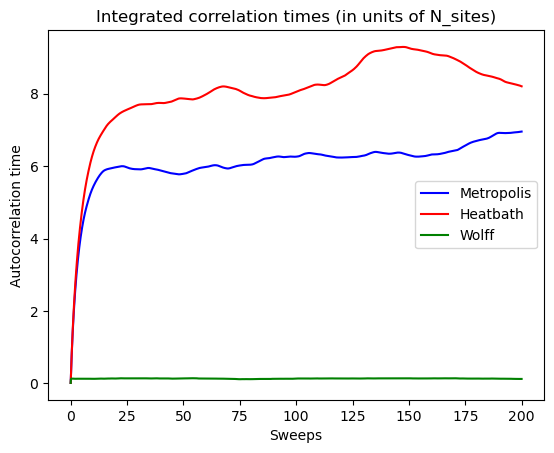

In [120]:
fig, ax = plt.subplots(1,1)

xrange=np.arange(time_stop)/N_sites
legend = ["Metropolis", "Heatbath", "Wolff"]

ax.plot(xrange, E_corr_time_set_M/N_sites, color="blue")
ax.plot(xrange, E_corr_time_set_H/N_sites, color="red")
ax.plot(xrange, E_corr_time_set_W/N_sites, color="green")

ax.set_xlabel("Sweeps")
ax.set_ylabel("Autocorrelation time")
ax.title.set_text("Integrated correlation times (in units of N_sites)")
plt.legend(legend)
ax.title
plt.show()

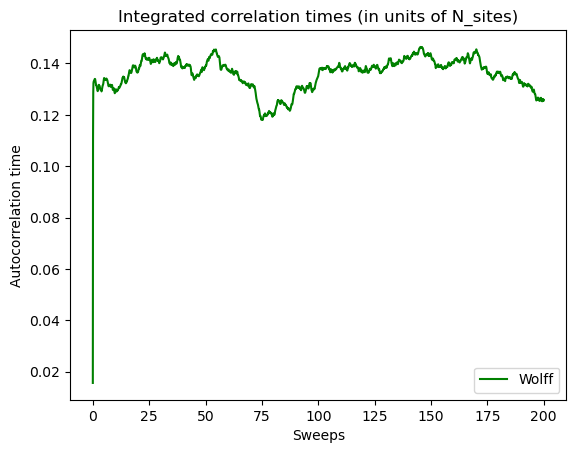

In [121]:
fig, ax = plt.subplots(1,1)

xrange=np.arange(time_stop)/N_sites
legend = ["Wolff"]
ax.plot(xrange, E_corr_time_set_W/N_sites, color="green")

ax.set_xlabel("Sweeps")
ax.set_ylabel("Autocorrelation time")
ax.title.set_text("Integrated correlation times (in units of N_sites)")
plt.legend(legend)
ax.title
plt.show()

## Correlation length and temperature

In [42]:
L,H = 4, 0
t_steps = 25
T_range = np.linspace(1,4,t_steps)

N_sites = L**2
N_burnin = 300*N_sites
N_iterations = 10**5*N_sites
time_stop = 200*N_sites

t0=time()
traces=[]
for t in T_range:
    beta=1/t
    trace = Metropolis_update(hotstart(L), beta, H, N_burnin + N_iterations)
    trace = trace[N_burnin:]
    traces.append(trace)

Mag_data=[np.abs(traces[i][:,0])/N_sites for i in range(len(traces))]
l_m=[exp_corr_len(auto_corr(Mag_data[i]))/N_sites for i in range(len(traces))]

E_data=[traces[i][:,1] for i in range(len(traces))]
l_e=[exp_corr_len(auto_corr(E_data[i]))/N_sites for i in range(len(traces))]

E_data=np.round(E_data,5)  ## Rounding off errors induced by non-zero H. Not sure fire but works for now

E_avg=[np.mean(E_data[i]) for i in range(len(traces))]
E_svar=[np.var(E_data[i], ddof=1)/len(E_data[i]) for i in range(len(traces))]
E_err=[1.96*np.sqrt(E_svar[i]) for i in range(len(traces))]

Mag_avg=[np.mean(Mag_data[i]) for i in range(len(traces))]
Mag_svar=[np.var(Mag_data[i], ddof=1)/len(Mag_data[i]) for i in range(len(traces))]
Mag_err=[1.96*np.sqrt(Mag_svar[i]) for i in range(len(traces))]

s_mean=[ np.mean(a) for a in E_data]
s_var=[np.var(e,ddof=1) for e in E_data]

# Compute exact results 

elist = [Ham(M,H) for M in config_gen(L)]
eset = sorted(set(elist))
    
E_mean=[sum( [ e*prob_E(L,t,H,e) for e in eset] ) for t in T_range]
E_var=[sum( [ (e-E_mean[i])**2*prob_Eset(L,T_range[i],H,[e]) for e in eset] ) for i in range(len(T_range))]

print("Computation time =" , time()-t0, " seconds, ", (time()-t0)/60, " minutes, or ", (time()-t0)/60**2, "hours.")

Computation time = 313.27180004119873  seconds,  5.221196667353312  minutes, or  0.08701994445588854 hours.


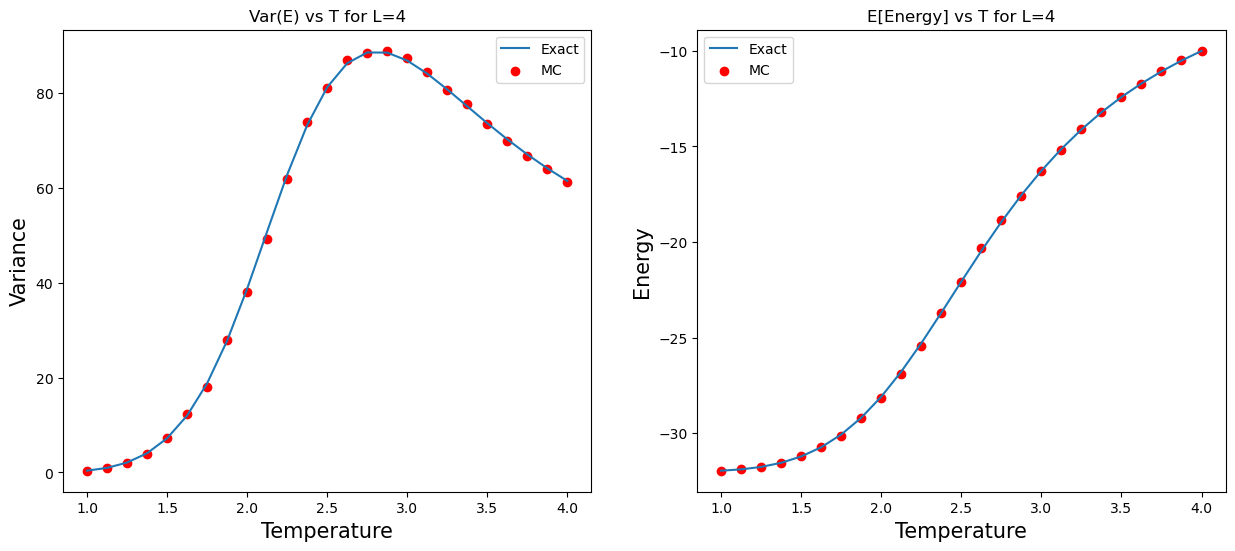

In [43]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(T_range, E_var, label="Exact")
ax[0].scatter(T_range,s_var, color="red", label="MC")
ax[0].set_xlabel("Temperature",fontsize=15) 
ax[0].set_ylabel("Variance" ,fontsize=15)
ax[0].set_title(f"Var(E) vs T for L={L}")
ax[0].legend()

ax[1].plot(T_range, E_mean, label="Exact")
ax[1].scatter(T_range,s_mean, color="red", label="MC")
ax[1].set_xlabel("Temperature",fontsize=15) 
ax[1].set_ylabel("Energy" ,fontsize=15)
ax[1].set_title(f"E[Energy] vs T for L={L}")
ax[1].legend()
plt.show()

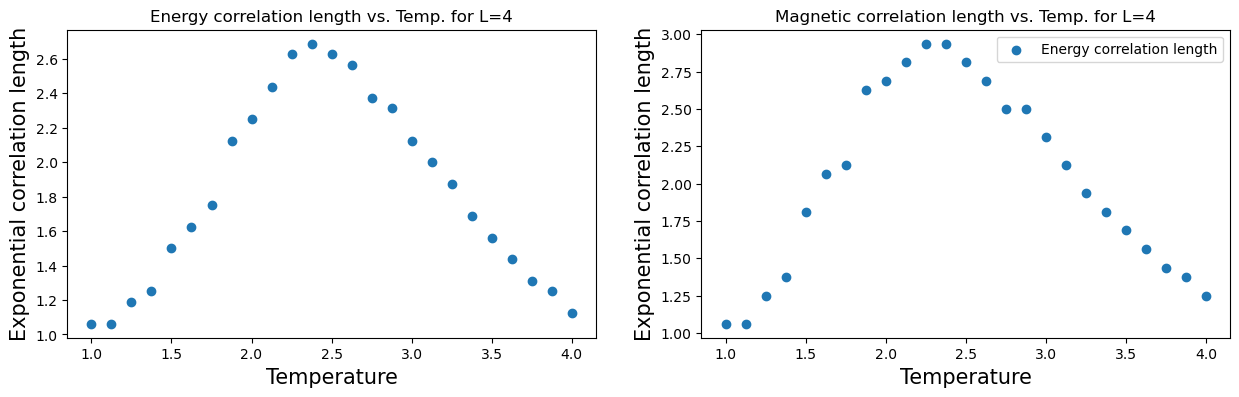

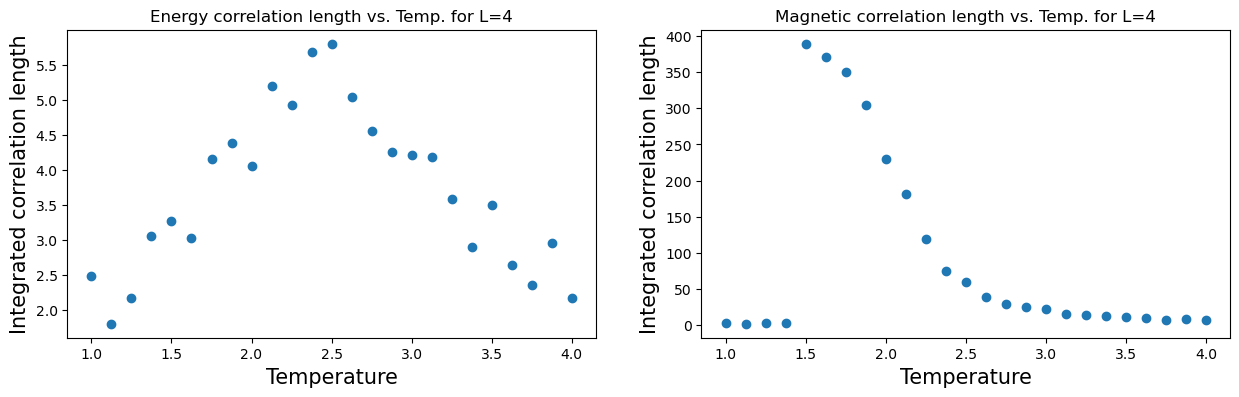

In [44]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].scatter(T_range,l_e)
ax[1].scatter(T_range,l_m)
ax[0].title.set_text(f"Energy correlation length vs. Temp. for L={L}")
ax[1].title.set_text(f"Magnetic correlation length vs. Temp. for L={L}")
[ax[i].set_xlabel("Temperature", fontsize=15) for i in range(len(ax))]
[ax[i].set_ylabel("Exponential correlation length" , fontsize=15) for i in range(len(ax))]
plt.legend(["Energy correlation length", "Magnetic correlation length"])
plt.show()

tau_t_M_set=[int_corr_time_set(traces[i][:,0],time_stop)/N_sites for i in range(len(traces))]
tau_t_E_set=[int_corr_time_set(traces[i][:,1],time_stop)/N_sites for i in range(len(traces))]
xrange=np.arange(time_stop)/N_sites

tau_M_set=[tau_t_M_set[i][-1] for i in range(len(tau_t_M_set))]
tau_E_set=[tau_t_E_set[i][-1] for i in range(len(tau_t_E_set))]

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].scatter(T_range, tau_E_set)
ax[1].scatter(T_range, tau_M_set)
ax[0].title.set_text(f"Energy correlation length vs. Temp. for L={L}")
ax[1].title.set_text(f"Magnetic correlation length vs. Temp. for L={L}")
[ax[i].set_xlabel("Temperature", fontsize=15) for i in range(len(ax))]
[ax[i].set_ylabel("Integrated correlation length" , fontsize=15) for i in range(len(ax))]
plt.show()

In [45]:
L,H = 8, 0
t_steps = 25
T_range = np.linspace(1,4,t_steps)

N_sites = L**2
N_burnin = 300*N_sites
N_iterations = 10**5*N_sites
time_stop = 200*N_sites

t0=time()
traces=[]
for t in T_range:
    beta=1/t
    trace = Metropolis_update(hotstart(L), beta, H, N_burnin + N_iterations)
    trace = trace[N_burnin:]
    traces.append(trace)

Mag_data = [np.abs(traces[i][:,0])/N_sites for i in range(len(traces))]
l_m = [exp_corr_len(auto_corr(Mag_data[i]))/N_sites for i in range(len(traces))]

E_data = [traces[i][:,1] for i in range(len(traces))]
l_e = [exp_corr_len(auto_corr(E_data[i]))/N_sites for i in range(len(traces))]

E_data = np.round(E_data,5)  ## Rounding off errors induced by non-zero H. Not sure fire but works for now

E_avg = [np.mean(E_data[i]) for i in range(len(traces))]
E_svar = [np.var(E_data[i], ddof=1)/len(E_data[i]) for i in range(len(traces))]
E_err = [1.96*np.sqrt(E_svar[i]) for i in range(len(traces))]

Mag_avg = [np.mean(Mag_data[i]) for i in range(len(traces))]
Mag_svar = [np.var(Mag_data[i], ddof=1)/len(Mag_data[i]) for i in range(len(traces))]
Mag_err = [1.96*np.sqrt(Mag_svar[i]) for i in range(len(traces))]

s_mean = [ np.mean(a) for a in E_data]
s_var = [np.var(e,ddof=1) for e in E_data]

# Compute exact results 

# elist = [Ham(M,H) for M in config_gen(L)]
# eset = sorted(set(elist))
    
# E_mean = [sum( [ e*prob_E(L,t,H,e) for e in eset] ) for t in T_range]
# E_var = [sum( [ (e-E_mean[i])**2*prob_Eset(L,T_range[i],H,[e]) for e in eset] ) for i in range(len(T_range))]

print("Computation time =" , time()-t0, " seconds, ", (time()-t0)/60, " minutes, or ", (time()-t0)/60**2, "hours.")

Computation time = 1238.328115940094  seconds,  20.6388020157814  minutes, or  0.3439800335963567 hours.


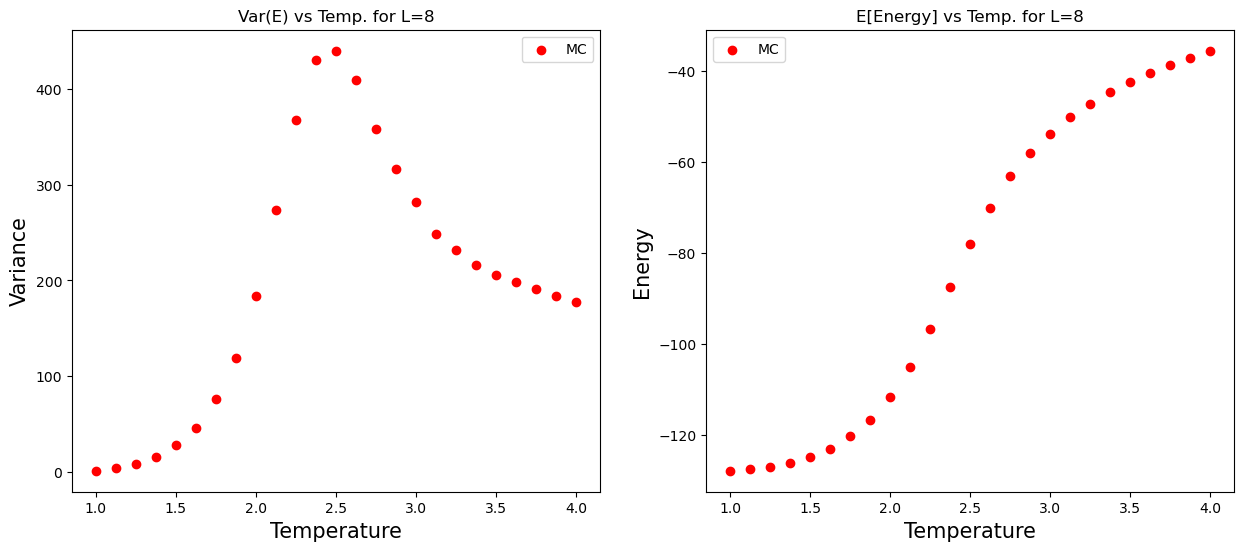

In [46]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].scatter(T_range,s_var, color="red", label="MC")
ax[0].set_xlabel("Temperature",fontsize=15) 
ax[0].set_ylabel("Variance" ,fontsize=15)
ax[0].set_title(f"Var(E) vs Temp. for L={L}")
ax[0].legend()

ax[1].scatter(T_range,s_mean, color="red", label="MC")
ax[1].set_xlabel("Temperature",fontsize=15) 
ax[1].set_ylabel("Energy" ,fontsize=15)
ax[1].set_title(f"E[Energy] vs Temp. for L={L}")
ax[1].legend()
plt.show()

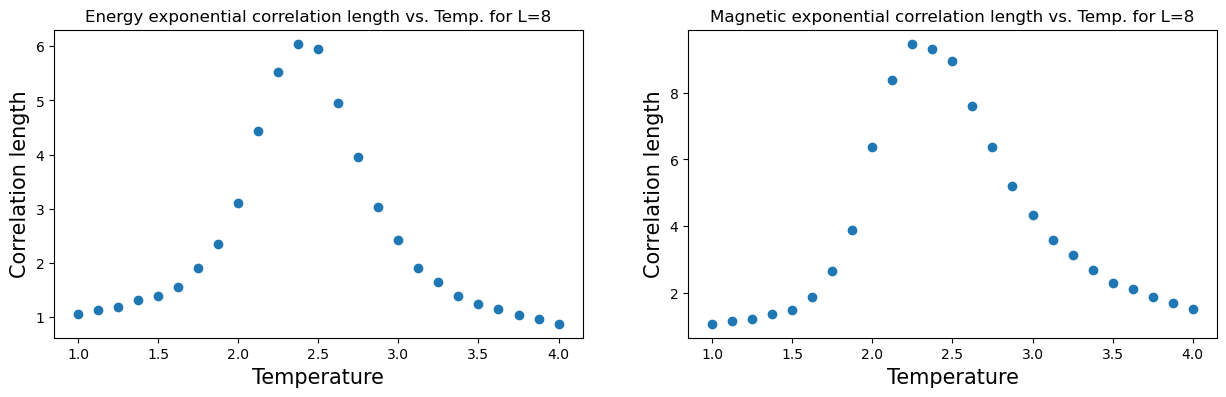

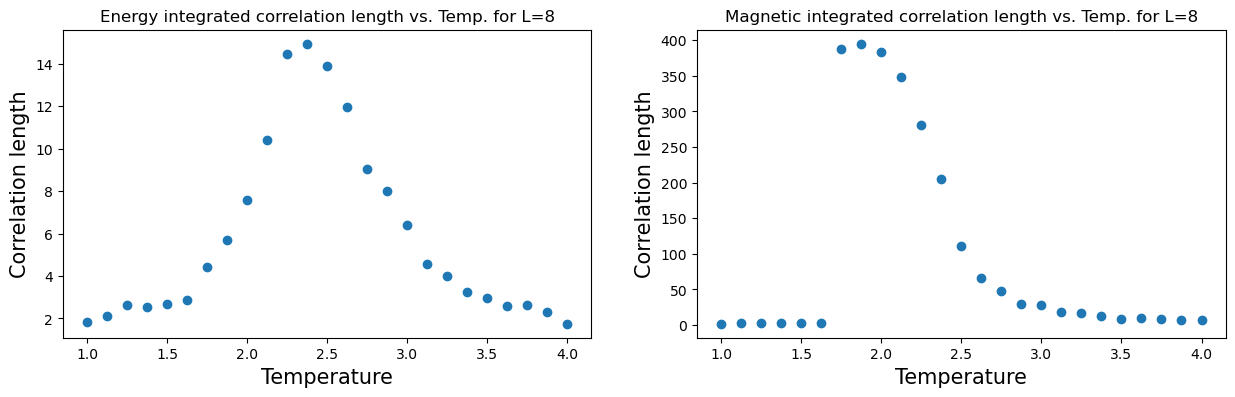

In [47]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].scatter(T_range, l_e)
ax[1].scatter(T_range, l_m)
ax[0].title.set_text(f"Energy exponential correlation length vs. Temp. for L={L}")
ax[1].title.set_text(f"Magnetic exponential correlation length vs. Temp. for L={L}")
[ax[i].set_xlabel("Temperature", fontsize=15) for i in range(len(ax))]
[ax[i].set_ylabel("Correlation length" , fontsize=15) for i in range(len(ax))]
plt.show()

tau_t_M_set=[int_corr_time_set(traces[i][:,0],time_stop)/N_sites for i in range(len(traces))]
tau_t_E_set=[int_corr_time_set(traces[i][:,1],time_stop)/N_sites for i in range(len(traces))]
xrange=np.arange(time_stop)/N_sites

tau_M_set=[tau_t_M_set[i][-1] for i in range(len(tau_t_M_set))]
tau_E_set=[tau_t_E_set[i][-1] for i in range(len(tau_t_E_set))]

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].scatter(T_range, tau_E_set)
ax[1].scatter(T_range, tau_M_set)
ax[0].title.set_text(f"Energy integrated correlation length vs. Temp. for L={L}")
ax[1].title.set_text(f"Magnetic integrated correlation length vs. Temp. for L={L}")
[ax[i].set_xlabel("Temperature", fontsize=15) for i in range(len(ax))]
[ax[i].set_ylabel("Correlation length" , fontsize=15) for i in range(len(ax))]
plt.show()